## 🍿 **1. Research Context and Problem Definition**



Understanding what drives audience ratings is a central question in movie analytics and recommendation systems.
The MovieLens 32M dataset provides a large-scale basis to explore this topic, combining millions of user ratings, tags, and movie metadata.
The guiding research question of this project is:
Which factors — genre, number of ratings, and popularity — most influence the average movie rating within the MovieLens dataset?
Addressing this question allows us to analyse both the structure and dynamics of how audiences evaluate films.
The study begins by exploring the distribution of ratings and creating derived metrics such as popularity, number of votes, and weighted averages.
Beyond descriptive analysis, this study also incorporates a temporal perspective to investigate whether audience behavior changes in response to major global events. In particular, we examined the impact of the COVID-19 pandemic and the war in Ukraine on viewing patterns; 
Overall, this work combines data exploration, statistical modeling, and temporal analysis to identify the factors that explain high movie ratings and to understand how user behavior reflects broader cultural and social trends.


## ⚙️ **2. Data Acquisition & Processing Pipeline**

### **2.1. Import necessary libraries and packages**

Need to install the packages listed on the requirements.txt, with the command: pip install -r requirements.txt

In [136]:
import polars as pl
import pandas as pd
import duckdb
import sys
import os
import gdown 
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa

In [137]:
print(sys.executable)

#"C:\Users\SaraEstevesHenriques\AppData\Local\Programs\Python\Python313\python.exe" -m pip install pyarrow
# use version 313 of python

C:\Users\RitaML\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


### **2.2. Import dataset files**

The files that compose the dataset for a complete analysis were stored on a Google Drive folder accessible by the direct URL.

The files came from 2 sources. The first part are parquet files downloaded from Movielens:

- Source of files: https://grouplens.org/datasets/movielens/
- Permalink: https://grouplens.org/datasets/movielens/32m/
- Version: MovieLens 32M

Description from the source:
MovieLens 32M movie ratings. Stable benchmark dataset. 32 million ratings and two million tag applications applied to 87,585 movies by 200,948 users. Collected 10/2023 Released 05/2024

The second source is a imdb file, available at:
- https://datasets.imdbws.com/

In [138]:
# Google Drive folder URL
folder_url = "https://drive.google.com/drive/folders/1azViEYTwDAw6rsQoWKGWyw8iDxQiHWrs?usp=drive_link"
output_dir = "data"

os.makedirs(output_dir, exist_ok=True)

# Download files in the folder, where the dataset with 32m registries is stored in parquet format
gdown.download_folder(url=folder_url, output=output_dir, quiet=False, use_cookies=False)


Retrieving folder contents


Processing file 1fvcBjElIX0_TbkDvyBos8PGfstclm_S1 BDF25_7.pptx
Processing file 1Kb6G1Wjiz1TycoN8yS7l8a1HJCdGdqpe links_32m.parquet
Processing file 1fr53kKllnm7YUQ_td0OTAxOaCWe6BiXg moviedetails.csv
Processing file 15iPCCprMP4AIUczoIQedLAGGEDgxnIMy movies_32m.parquet
Processing file 1-BUqGS_AxvUZcYZymNzMAk9l8JVsy1fs ratings_32m.parquet
Processing file 1H15eh-AlA-YS-5-IZbby-YWf5-5_LQ9F tags_32m.parquet
Processing file 1_asHmjb-F_qmNcadzprYAwNltw4azvdp title.basics.tsv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1fvcBjElIX0_TbkDvyBos8PGfstclm_S1
To: c:\Users\SaraEstevesHenriques\OneDrive - VortalSA\Documents\GitHub\BDF25_7\BDF25_7_data\big_data\ml-32m\data\BDF25_7.pptx
100%|██████████| 5.37M/5.37M [00:00<00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kb6G1Wjiz1TycoN8yS7l8a1HJCdGdqpe
To: c:\Users\RitaML\Documents\GitHub\BDF25_7\BDF25_7_data\big_data\ml-32m\data\links_32m.parquet
100%|██████████| 1.34M/1.34M [00:00<00:00, 4.17MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fr53kKllnm7YUQ_td0OTAxOaCWe6BiXg
To: c:\Users\RitaML\Documents\GitHub\BDF25_7\BDF25_7_data\big_data\ml-32m\data\moviedetails.csv
100%|██████████| 6.87M/6.87M [00:00<00:00, 7.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=15iPCCprMP4AIUczoIQedLAGGEDgxnIMy
To: c:\Users\RitaML\Documents\GitHub\BDF25_7\BDF25_7_data\big_data\ml-32m

['data\\BDF25_7.pptx',
 'data\\links_32m.parquet',
 'data\\moviedetails.csv',
 'data\\movies_32m.parquet',
 'data\\ratings_32m.parquet',
 'data\\tags_32m.parquet',
 'data\\title.basics.tsv']

Note that on the first approach and exploration DuckBD was used locally and also on this repository. However, we found much simplier to have the connection and create the tables to work later.

In [139]:
#check the available parquet files
files = [f for f in os.listdir("data") if f.endswith(".parquet")|f.endswith(".tsv")|f.endswith(".csv")]
print("Available Parquet and TSV files:")
for f in files:
    print(f)

Available Parquet and TSV files:
links_32m.parquet
moviedetails.csv
movies_32m.parquet
ratings_32m.parquet
tags_32m.parquet
title.basics.tsv


#### **2.2.1. Create Movies table**

In [140]:
#Using DuckDB to read Parquet files and tranform the data into Polars DataFrames
con = duckdb.connect()

df_movies = pl.read_parquet("data/movies_32m.parquet")
df_movies.head()

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance"""
5,"""Father of the Bride Part II (1…","""Comedy"""


#### **2.2.2. Create Ratings table**

In [141]:
con = duckdb.connect()

df_ratings = pl.read_parquet("data/ratings_32m.parquet")
df_ratings.head()

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,17,4.0,944249077
1,25,1.0,944250228
1,29,2.0,943230976
1,30,5.0,944249077
1,32,5.0,943228858


#### **2.2.3. Create Links table**

In [142]:
con = duckdb.connect()

df_links = pl.read_parquet("data/links_32m.parquet")
df_links.head()

movieId,imdbId,tmdbId
i64,str,i64
1,"""0114709""",862
2,"""0113497""",8844
3,"""0113228""",15602
4,"""0114885""",31357
5,"""0113041""",11862


#### **2.2.4. Create Tags table**

In [143]:
con = duckdb.connect()

df_tags = pl.read_parquet("data/tags_32m.parquet")
df_tags.head()

userId,movieId,tag,timestamp
i64,i64,str,i64
22,26479,"""Kevin Kline""",1583038886
22,79592,"""misogyny""",1581476297
22,247150,"""acrophobia""",1622483469
34,2174,"""music""",1249808064
34,2174,"""weird""",1249808102


#### **2.2.5. Create imdb_df**

In [144]:
imdb_df = pd.read_csv("data/title.basics.tsv", sep="\t", low_memory=False)

print(imdb_df.columns)
imdb_df.head()

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


Doing the import using polars is faster

In [145]:
imdb_df_1 = pl.read_csv(
    "data/title.basics.tsv",
    separator="\t", null_values="\\N",quote_char=None

)
imdb_df_1.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,str,str,str,i64,i64,str,i64,str
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Documentary,Short"""
"""tt0000002""","""short""","""Le clown et ses chiens""","""Le clown et ses chiens""",0,1892,null,5,"""Animation,Short"""
"""tt0000003""","""short""","""Poor Pierrot""","""Pauvre Pierrot""",0,1892,null,5,"""Animation,Comedy,Romance"""
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"""Animation,Short"""
"""tt0000005""","""short""","""Blacksmith Scene""","""Blacksmith Scene""",0,1893,null,1,"""Short"""


## **3. Initial Data Profiling - Understading the data**

On the previous chapter the files that compose the dataset for analysis were loaded. 
In this chapter the main goal is to understand the data available in each table and connect them.

### **3.1. Movies**

#### **3.1.1. Info & Shape** 

Movies table has the  Movieid, Title and the movie Genres. Looking for the first lines it is possible to understand that some titles have also the movie year and the genres columns has multiple values listed splited by "|". Both of this values will require treatment for analysis.
There are 87 585 movies on this dataframe.

In [146]:
df_movies.shape

(87585, 3)

In [147]:
df_movies.head(10)

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance"""
5,"""Father of the Bride Part II (1…","""Comedy"""
6,"""Heat (1995)""","""Action|Crime|Thriller"""
7,"""Sabrina (1995)""","""Comedy|Romance"""
8,"""Tom and Huck (1995)""","""Adventure|Children"""
9,"""Sudden Death (1995)""","""Action"""


#### **3.1.2. Genres Treatment - transforming "(no genres listed)" into nulls** 

There are movies with the genre set as "(no genres listed)" - this will be turned into nulls.

In [148]:
df_movies = df_movies.with_columns(
    pl.col("genres").replace("(no genres listed)", None)
)

df_movies.head()

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance"""
5,"""Father of the Bride Part II (1…","""Comedy"""


#### **3.1.3. Duplicate analysis**

The dataset has 401 movies identified with the exact same title, which at this point is composed by the name and te year.

In [149]:
duplicated_movies = df_movies.filter(pl.col("title").is_duplicated())
print(f"Number of movies with the same title: {len(duplicated_movies)}")

Number of movies with the same title: 401


In [150]:
#Check some examples of duplicated titles
duplicated_movies.sort("title", descending=True)


movieId,title,genres
i64,str,str
184301,"""Yellow (2006)""","""Drama|Romance"""
274159,"""Yellow (2006)""",null
195275,"""White Lily (2016)""","""Drama|Sci-Fi"""
216597,"""White Lily (2016)""","""Drama"""
91199,"""Weekend (2011)""","""Drama|Romance"""
…,…,…
151797,"""Absolution (2015)""","""Drama|Thriller"""
96456,"""ATM (2012)""","""Horror|Thriller"""
217057,"""ATM (2012)""","""Comedy|Romance"""


After a quick search on IMBD we can conclude that although the name and year are the same, the lines correspondent to different movies.
For instance the first example, regarding Yellow (2006), there is a movie and also a short with the same name. The same was found for White Lily (2016). 

#### **3.1.4. Titles - spliting the year**

The titles in most cases have the actual title and the movie year. The first step is to split both of this informations. 

In [151]:
df_movies_1 = df_movies.with_columns([
    # Extract year, the 4 numbers inside the "". If no year is found it will be null
    pl.col("title").str.extract(r'\((\d{4})\)', 1).cast(pl.Int64).alias("year"),
    # Remove year from title (removes the pattern " (YYYY)" or "(YYYY)")
    pl.col("title").str.replace(r'\s*\(\d{4}\)', '').str.strip_chars('"').alias("title")
])

In [152]:
df_movies_1.head()

movieId,title,genres,year
i64,str,str,i64
1,"""Toy Story""","""Adventure|Animation|Children|C…",1995
2,"""Jumanji""","""Adventure|Children|Fantasy""",1995
3,"""Grumpier Old Men""","""Comedy|Romance""",1995
4,"""Waiting to Exhale""","""Comedy|Drama|Romance""",1995
5,"""Father of the Bride Part II""","""Comedy""",1995


After the split the year from the title we can conclude that there are 615 movies without that data.

In [153]:
df_movies_1.null_count()

movieId,title,genres,year
u32,u32,u32,u32
0,0,7080,615


#### **3.1.5. Titles - spliting the genres**

Since a movie has multiple genres the funcion explode will be used to split them.

In [154]:
df_movies_exploded = (
    df_movies_1
    .with_columns(pl.col("genres").str.split("|"))
    .explode("genres")
    .rename({"genres": "genre"})  # renomear diretamente
    .select(["movieId", "title", "year", "genre"])
    .filter(pl.col("genre").is_not_null() & (pl.col("genre") != ""))
)

df_movies_exploded.head()

movieId,title,year,genre
i64,str,i64,str
1,"""Toy Story""",1995,"""Adventure"""
1,"""Toy Story""",1995,"""Animation"""
1,"""Toy Story""",1995,"""Children"""
1,"""Toy Story""",1995,"""Comedy"""
1,"""Toy Story""",1995,"""Fantasy"""


#### Output: df_movies_1 and df_movies_exploded

### **3.2. Ratings**

#### **3.2.1. Info & Shape** 

Ratings table has more than 32 million registers. 

In [155]:
df_ratings.shape

(32000204, 4)

In [156]:
df_ratings.head()

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,17,4.0,944249077
1,25,1.0,944250228
1,29,2.0,943230976
1,30,5.0,944249077
1,32,5.0,943228858


#### **3.2.2. Timestamp conversion**

According with dataset source, the Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. For human understand we need to convert this value to a datetime.


In [157]:
# Convert the 'timestamp' column to datetime and create a new column 'date'
df_ratings = df_ratings.with_columns(
    (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
)

# The * by 1000 is because the original timestamp is in seconds, and we need milliseconds for polars

df_ratings.head()

userId,movieId,rating,timestamp,datetime
i64,i64,f64,i64,datetime[ms]
1,17,4.0,944249077,1999-12-03 19:24:37
1,25,1.0,944250228,1999-12-03 19:43:48
1,29,2.0,943230976,1999-11-22 00:36:16
1,30,5.0,944249077,1999-12-03 19:24:37
1,32,5.0,943228858,1999-11-22 00:00:58


There are no null values:

In [158]:
df_ratings.null_count()

userId,movieId,rating,timestamp,datetime
u32,u32,u32,u32,u32
0,0,0,0,0


#### **3.2.3. Understanding ratings**

For further analysis the following query has as main goal understand if one user can make multiple ratings for the same movie. The conclusion is no. 

In [159]:

# Connect to DuckDB (in-memory or to a file)
con = duckdb.connect(database=":memory:")

# Define the file path, in this case data folder
ratings_path= "data/ratings_32m.parquet"

# SQL statement
queryrating = f"""
SELECT userId, movieId, COUNT(*) as rating_count
FROM read_parquet('{ratings_path}')
GROUP BY userId, movieId
HAVING COUNT(*) > 1
"""

# Execute the query and fetch results as a Polars DataFrame
print (con.execute(queryrating).pl())


shape: (0, 3)
┌────────┬─────────┬──────────────┐
│ userId ┆ movieId ┆ rating_count │
│ ---    ┆ ---     ┆ ---          │
│ i64    ┆ i64     ┆ i64          │
╞════════╪═════════╪══════════════╡
└────────┴─────────┴──────────────┘


### **3.3. Links**

This table is usefull to link the data with the imbd data. Therefore, this table as the same number of lines of df_movies, the original movies table.

#### **3.3.1. Info & Shape** 

In [160]:
df_movies.shape

(87585, 3)

In [161]:
df_links.head()

movieId,imdbId,tmdbId
i64,str,i64
1,"""0114709""",862
2,"""0113497""",8844
3,"""0113228""",15602
4,"""0114885""",31357
5,"""0113041""",11862


#### **3.3.2. Understanding IMDB and MovieLens link** 

The 0114709 imbd id corresponds to our movie number 1, Toy Story from 1995.

In [162]:
# Filter IMDB data for imdbId '0114709' 
imdb_id = "3387520"
tconst = f"tt{imdb_id}"

# Using polars dataframe (imdb_df_1), created on the 2.2.5.
example = imdb_df_1.filter(pl.col("tconst") == tconst)
example 

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,str,str,str,i64,i64,str,i64,str
"""tt3387520""","""movie""","""Scary Stories to Tell in the D…","""Scary Stories to Tell in the D…",0,2019,null,108,"""Adventure,Horror,Mystery"""


In [163]:
df_movies.filter(pl.col("movieId") == 203208)

movieId,title,genres
i64,str,str
203208,"""Scary Stories to Tell in the D…","""Horror"""


### **3.4. Tags**

#### **3.4.1. Info & Shape** 

Tags has more than 2 million lines with comments made by users. Checking just the first lines it is possible to conclude that the timestamp needs to be treated as before.

In [164]:
df_tags.shape

(2000072, 4)

In [165]:
df_tags.head()

userId,movieId,tag,timestamp
i64,i64,str,i64
22,26479,"""Kevin Kline""",1583038886
22,79592,"""misogyny""",1581476297
22,247150,"""acrophobia""",1622483469
34,2174,"""music""",1249808064
34,2174,"""weird""",1249808102


#### **3.4.2. Timestamp conversion**

In [166]:
# Convert the 'timestamp' column to datetime and create a new column 'date'
df_tags= df_tags.with_columns(
    (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
)

# The * by 1000 is because the original timestamp is in seconds, and we need milliseconds for polars

df_tags.head()

userId,movieId,tag,timestamp,datetime
i64,i64,str,i64,datetime[ms]
22,26479,"""Kevin Kline""",1583038886,2020-03-01 05:01:26
22,79592,"""misogyny""",1581476297,2020-02-12 02:58:17
22,247150,"""acrophobia""",1622483469,2021-05-31 17:51:09
34,2174,"""music""",1249808064,2009-08-09 08:54:24
34,2174,"""weird""",1249808102,2009-08-09 08:55:02


#### **3.4.3. Understanding Tags**

The main goal of this query is to understand if one user can make multiple tags for the same movie and the answer is yes. On the ratings there is only one per user, however, what concerns to tags one user can make multiple for the same movie.

In [167]:
# Connect to DuckDB (in-memory or to a file)
con = duckdb.connect(database=":memory:")

# Define the file path, in this case data folder
tags_path= "data/tags_32m.parquet"

# SQL statement
querytags = f"""
SELECT userId, movieId, COUNT(*) as tag_count
FROM read_parquet('{tags_path}')
GROUP BY userId, movieId
HAVING COUNT(*) > 1
"""

# Execute the query and fetch results as a Polars DataFrame
print (con.execute(querytags).pl())

shape: (236_143, 3)
┌────────┬─────────┬───────────┐
│ userId ┆ movieId ┆ tag_count │
│ ---    ┆ ---     ┆ ---       │
│ i64    ┆ i64     ┆ i64       │
╞════════╪═════════╪═══════════╡
│ 17035  ┆ 214658  ┆ 2         │
│ 17035  ┆ 214951  ┆ 2         │
│ 17035  ┆ 226692  ┆ 4         │
│ 17035  ┆ 226694  ┆ 2         │
│ 17035  ┆ 228563  ┆ 12        │
│ …      ┆ …       ┆ …         │
│ 78213  ┆ 274967  ┆ 2         │
│ 78213  ┆ 276561  ┆ 24        │
│ 78213  ┆ 276567  ┆ 12        │
│ 83284  ┆ 1594    ┆ 3         │
│ 83284  ┆ 3826    ┆ 3         │
└────────┴─────────┴───────────┘


### **3.5. Cross Analysis: Querying using Athena**

In order to have a global view of the data that we have to work with, the following query joins the movies, ratings and tags table.
This query was very heavy to run locally, so it is connected to Athena.

The dataframe that results from the query gives an average rating per movie and the count of ratings made per each. Also the count of tags per movie and the number of different users that have evaluated it. 


In [170]:
import polars as pl
from pyathena import connect
from pyathena.arrow.cursor import ArrowCursor
from dotenv import load_dotenv

#Load the environment variables from the .env file, where the AWS credentials are stored
load_dotenv(override=True)


DATABASE = "bdf_25_7_ml_32m"

# Connect with ArrowCursor because it is more efficient for large datasets
with connect(
    s3_staging_dir='s3://bdf-25-7/queries-ml-32-m/',
    region_name='us-east-1',
    cursor_class=ArrowCursor
).cursor() as cursor:
    
    query = f"""
    WITH rating_stats AS (
    SELECT 
        movieId,
        AVG(rating) AS average_rating,
        COUNT(rating) AS rating_count
    FROM bdf_25_7_ml_32m.ratings
    GROUP BY movieId
    ),
    tag_stats AS (
        SELECT 
            movieId,
            COUNT(*) AS tag_count_per_movie,
            COUNT(DISTINCT userId) AS user_count_tags  -- unique users that made tags
        FROM bdf_25_7_ml_32m.tag
        GROUP BY movieId
    )
    SELECT 
        m.movieId,
        m.title,
        m.genres,
        COALESCE(r.average_rating, 0) AS average_rating,
        COALESCE(r.rating_count, 0) AS rating_count,
        COALESCE(t.tag_count_per_movie, 0) AS tag_count_per_movie, --user_count_per_movie
        COALESCE(t.user_count_tags, 0) AS user_count_tags  
    FROM bdf_25_7_ml_32m.movies m
    LEFT JOIN rating_stats r ON m.movieId = r.movieId
    LEFT JOIN tag_stats t ON m.movieId = t.movieId
    """

    cursor.execute(query)
    
    # Use as_arrow() instead of fetch_arrow_table()
    arrow_table = cursor.as_arrow()
    df = pl.from_arrow(arrow_table)



Failed to execute query.
Traceback (most recent call last):
  File "C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyathena\common.py", line 645, in _execute
    query_id = retry_api_call(
               ~~~~~~~~~~~~~~^
        self._connection.client.start_query_execution,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<2 lines>...
        **request,
        ^^^^^^^^^^
    ).get("QueryExecutionId")
    ^
  File "C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyathena\util.py", line 196, in retry_api_call
    return retry(func, *args, **kwargs)
  File "C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tenacity\__init__.py", line 477, in __call__
    do = self.iter(retry_state=retry_state)
  File "C:\

DatabaseError: An error occurred (AccessDeniedException) when calling the StartQueryExecution operation: You are not authorized to perform: athena:StartQueryExecution on the resource. After your AWS administrator or you have updated your permissions, please try again.

In [171]:
df.head()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags
i64,str,str,f64,i64,i64,i64
203214,"""The Criminal and the Lady (196…","""Crime|Mystery|Thriller""",3.0,2,0,0
203216,"""The Second Wind (2007)""","""Crime|Drama|Mystery|Thriller""",0.5,1,0,0
203218,"""Good Boys (2019)""","""Comedy""",3.490368,571,66,15
203220,"""Being Frank (2019)""","""Comedy""",2.854167,24,0,0
203224,"""Dora and the Lost City of Gold…","""Adventure|Children|Comedy""",2.919431,211,28,6


Due to the connection requirements the data was saved directly on a csv, available on this project under the name moviedetails.  The next cell is imports that same file to a df and will be used later.

In [172]:
#the cvs is on this folder and its called moviedetails csv
df_moviedetails = pl.read_csv("data/moviedetails.csv")
print("CSV read successfully. Shape:", df_moviedetails.shape)
display(df_moviedetails .head())

CSV read successfully. Shape: (87585, 7)


movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags
i64,str,str,f64,i64,i64,i64
203196,"""The Fall of the Romanov Dynast…","""Documentary""",2.0,4,2,1
203200,"""So You Want a Television Set (…","""(no genres listed)""",2.5,1,0,0
203202,"""Killer Bean Forever (2009)""","""Action|Animation""",2.642857,21,7,1
203204,"""Angel Dust (1994)""","""Drama|Horror|Romance""",3.583333,12,0,0
203206,"""This Is Not Berlin (2019)""","""Drama""",2.75,10,7,1


In [173]:
df_moviedetails.describe() ## or df.describe() if you're able to run with athena. gives the same!

statistic,movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags
str,f64,str,str,f64,f64,f64,f64
"""count""",87585.0,"""87585""","""87585""",87585.0,87585.0,87585.0,87585.0
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",157651.365519,null,null,2.896901,365.361694,22.835782,3.996598
"""std""",79013.402099,null,null,0.966004,2546.327582,124.680894,20.024017
"""min""",1.0,""" (2019)""","""(no genres listed)""",0.0,0.0,0.0,0.0
"""25%""",112657.0,null,null,2.5,2.0,0.0,0.0
"""50%""",165741.0,null,null,3.0,5.0,1.0,1.0
"""75%""",213203.0,null,null,3.5,23.0,7.0,2.0
"""max""",292757.0,"""줄탁동시 (2012)""","""Western""",5.0,102929.0,6697.0,2007.0


#### **3.5.1. Transforming Summary dataframe - MovieDetails**

##### 3.5.1.1. Extracting the year

Extracting the year as made before:

In [174]:
df_moviedetails = df_moviedetails.with_columns([
    # Extract year, the 4 numbers inside the "". If no year is found it will be null
    pl.col("title").str.extract(r'\((\d{4})\)', 1).cast(pl.Int64).alias("year"),
    # Remove year from title (removes the pattern " (YYYY)" or "(YYYY)")
    pl.col("title").str.replace(r'\s*\(\d{4}\)', '').str.strip_chars('"').alias("title")
])

In [175]:
df_moviedetails.head()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags,year
i64,str,str,f64,i64,i64,i64,i64
203196,"""The Fall of the Romanov Dynast…","""Documentary""",2.0,4,2,1,1927
203200,"""So You Want a Television Set""","""(no genres listed)""",2.5,1,0,0,1953
203202,"""Killer Bean Forever""","""Action|Animation""",2.642857,21,7,1,2009
203204,"""Angel Dust""","""Drama|Horror|Romance""",3.583333,12,0,0,1994
203206,"""This Is Not Berlin""","""Drama""",2.75,10,7,1,2019


##### 3.5.1.2. Creating a threshold

For our analysis we'll consider only movies with more than 50 reviews.

In [176]:
df_moviedetails =  df_moviedetails.filter(pl.col("rating_count") > 50) 


In [177]:
# Transform (no genres listed) to null
df_moviedetails = df_moviedetails.with_columns(
    pl.col("genres").replace("(no genres listed)", None)
)

# Check for null values in each column
print("Before NULL removal \n", df_moviedetails.null_count())

# Filter out rows with null genres or year
df_moviedetails = df_moviedetails.filter(
    pl.col("genres").is_not_null() & pl.col("year").is_not_null()
)
print("After NULL removal", df_moviedetails.null_count())

Before NULL removal 
 shape: (1, 8)
┌─────────┬───────┬────────┬────────────────┬──────────────┬────────────────┬───────────────┬──────┐
│ movieId ┆ title ┆ genres ┆ average_rating ┆ rating_count ┆ tag_count_per_ ┆ user_count_ta ┆ year │
│ ---     ┆ ---   ┆ ---    ┆ ---            ┆ ---          ┆ movie          ┆ gs            ┆ ---  │
│ u32     ┆ u32   ┆ u32    ┆ u32            ┆ u32          ┆ ---            ┆ ---           ┆ u32  │
│         ┆       ┆        ┆                ┆              ┆ u32            ┆ u32           ┆      │
╞═════════╪═══════╪════════╪════════════════╪══════════════╪════════════════╪═══════════════╪══════╡
│ 0       ┆ 0     ┆ 85     ┆ 0              ┆ 0            ┆ 0              ┆ 0             ┆ 46   │
└─────────┴───────┴────────┴────────────────┴──────────────┴────────────────┴───────────────┴──────┘
After NULL removal shape: (1, 8)
┌─────────┬───────┬────────┬────────────────┬──────────────┬────────────────┬───────────────┬──────┐
│ movieId ┆ title ┆ ge

#### **3.1.1. Top 10 movies by average rating**

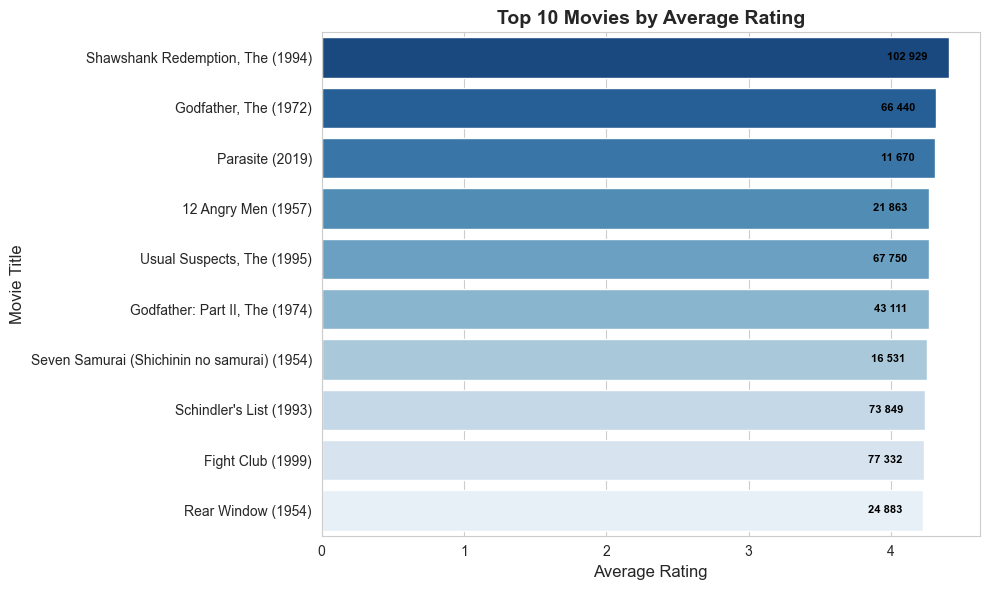

In [178]:
top10_pl = (
    df_moviedetails
    .filter(pl.col("rating_count") > 10000)
    .sort("average_rating", descending=True)
    .select([
        (pl.col("title") + " (" + pl.col("year").cast(pl.Utf8) + ")").alias("title"),
        "average_rating", 
        "rating_count"
    ])
    .head(10)
)

top10_pd = pd.DataFrame({
    'title': top10_pl['title'].to_list(),
    'average_rating': top10_pl['average_rating'].to_list(),
    'rating_count': top10_pl['rating_count'].to_list()
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=top10_pd,
    x='average_rating',
    y='title',
    hue='title',
    palette='Blues_r',
    legend=False,
    ax=ax
)

# Add the count of ratings inside the bars
for i, (rating, count) in enumerate(zip(top10_pd['average_rating'], top10_pd['rating_count'])):
    ax.text(
        rating - 0.15, 
        i, 
        f"{count:,}".replace(",", " "),  
        va='center', 
        ha='right',   
        fontsize=8,
        color='black',  
        fontweight='bold'
    )

ax.set_xlabel('Average Rating', fontsize=12)
ax.set_ylabel('Movie Title', fontsize=12)
ax.set_title('Top 10 Movies by Average Rating', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 🧩 **4. Exploratory Data Analysis & Visual Insights**

This section brings together the main findings from the analysis of the MovieLens 32M dataset, combining exploratory and temporal perspectives to understand what drives user ratings and how global events may influence viewing patterns.
Each subsection follows the same structure:
* A data-driven question that guides the analysis;
* The SQL or Polars query used to extract and transform the data;
* A visualization that illustrates the results;
* A brief interpretation summarizing the main takeaway.

We began by examining which factors explain higher ratings, focusing on genre, popularity, and user behavior. This exploratory analysis looks at how ratings vary by genre, how the number of ratings relates to perceived quality, and whether highly active users evaluate films differently from casual ones.
The study then extends to a temporal dimension, analysing how user engagement and film preferences evolved during key global events. Two case studies were chosen:
The COVID-19 pandemic (declared March 11, 2020), to explore whether confinement and increased screen time affected the volume or sentiment of ratings.
The war in Ukraine (beginning February 24, 2022), to assess whether audiences showed increased interest in War and Documentary films during and after the conflict.
Together, these analyses connect user-level behaviour with larger social contexts, revealing how intrinsic factors — such as genre and popularity — consistently shape evaluations, while external events can briefly shift what audiences choose to watch without fundamentally changing how they rate films.


### 🎭 Question 1 — What are the most popular genres?

We start by identifying which genres receive the **highest number of ratings**.
This indicates popularity and audience engagement across the platform.


In [179]:
df_genres = (
    df_moviedetails
    .with_columns(
        pl.col("genres").str.split("|")  
    )
    .explode("genres")  
    .group_by("genres")
    .agg([
        pl.col("rating_count").sum().alias("total_ratings"), 
        pl.col("average_rating").mean().alias("avg_rating")   
    ])
    .sort("total_ratings", descending=True)
    .head(10)  
)


In [180]:
df_genres_pd = df_genres.to_pandas()


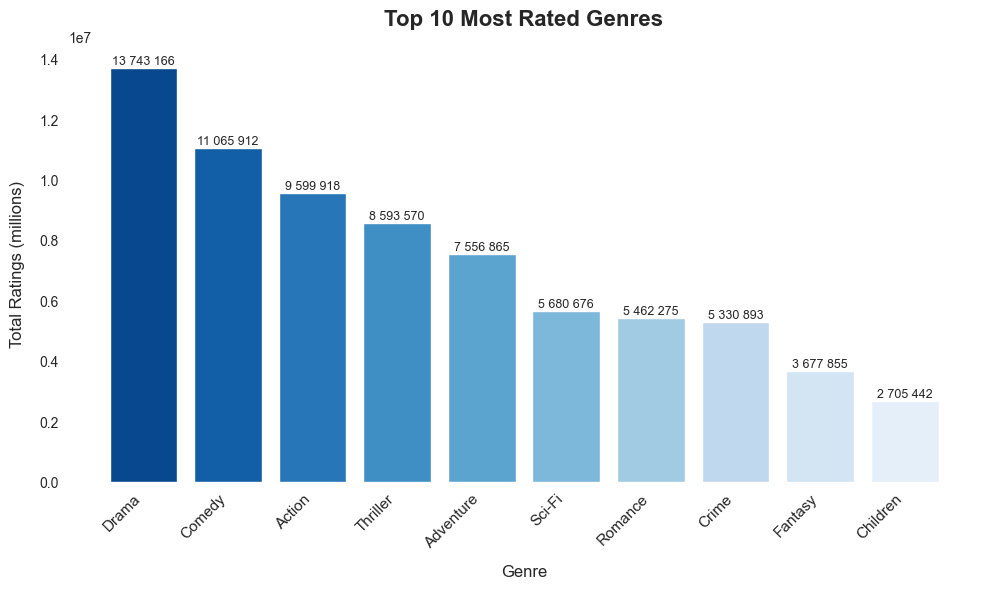

In [181]:
sns.set_style("white")
plt.figure(figsize=(10, 6))

bars = plt.bar(
    df_genres_pd["genres"],
    df_genres_pd["total_ratings"],
    color=sns.color_palette("Blues_r", len(df_genres_pd)),
    edgecolor="white",
    linewidth=1
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 150,
        f"{int(height):,}".replace(",", " "),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="medium"
    )

plt.title("Top 10 Most Rated Genres", fontsize=16, weight="bold", pad=15)
plt.xlabel("Genre", fontsize=12, labelpad=10)
plt.ylabel("Total Ratings (millions)", fontsize=12, labelpad=10)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### 💡 **Insight**

From the visualization, it becomes evident that **Drama** stands out as the most popular genre, 
accumulating the highest number of ratings overall. **Action** and **Thriller** follow closely, 
reflecting their sustained audience engagement and mainstream appeal.  
Genres such as **Romance**, **Mystery**, and **Fantasy** appear with significantly fewer ratings, 
suggesting a more niche audience or less frequent interaction from users.


## 🎯 Question 2 — What are the highest rated genres?

After understanding which genres receive the largest number of ratings — representing *popularity* — 
we now shift the focus to **quality perception**.  
In this step, we aim to identify which genres achieve the **highest average ratings**, 
revealing users’ most appreciated types of movies.

This analysis highlights genres that, although possibly less mainstream, 
tend to receive consistently higher evaluations from users.


In [182]:
df_moviedetails_exploded = (
    df_moviedetails
    .with_columns([
        pl.col("genres").str.split("|")
    ])
    .explode("genres")
    .rename({"genres": "genre"})
    .select(["movieId", "title", "genre", "year", "average_rating", "rating_count"])
    .filter(pl.col("genre").is_not_null() & (pl.col("genre") != ""))
)

In [183]:
df_genres_avg = (
    df_moviedetails_exploded
    .group_by("genre")
    .agg([
        pl.col("average_rating").mean().alias("avg_rating"),
        pl.len().alias("n_movies")
    ])
    .sort("avg_rating", descending=True)
    .head(10)
)
df_genres_avg_pd = df_genres_avg.to_pandas()
df_genres_avg_pd


,genre,avg_rating,n_movies
0,Film-Noir,3.645527,145
1,Documentary,3.601594,863
2,War,3.501468,624
3,Drama,3.409698,7405
4,Western,3.342138,298
5,Animation,3.337735,954
6,Romance,3.324804,2383
7,Musical,3.321817,503
8,Crime,3.317691,1842
9,Mystery,3.303818,963


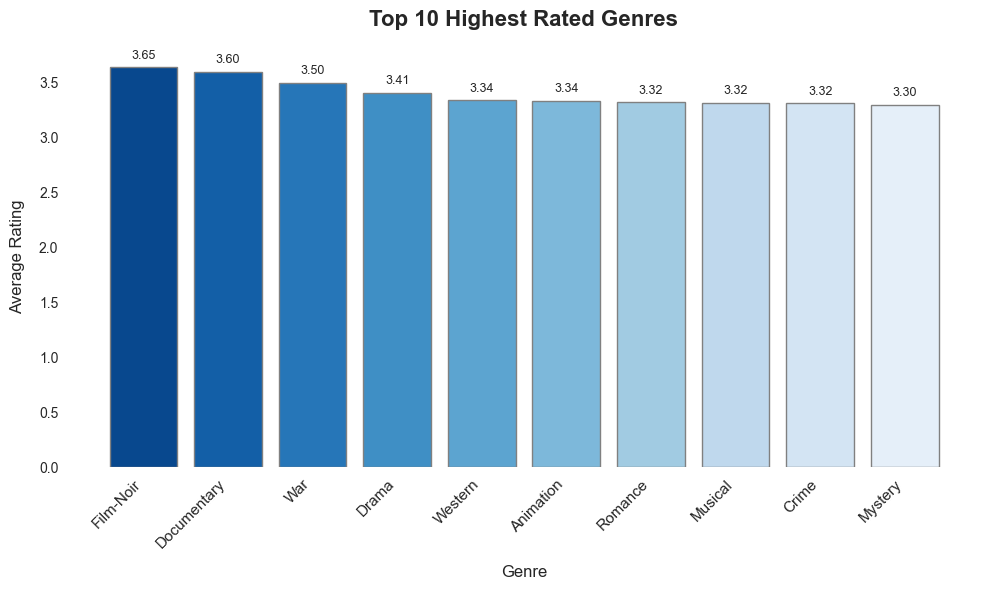

In [184]:
sns.set_style("white")
plt.figure(figsize=(10, 6))

bars = plt.bar(
    df_genres_avg_pd["genre"],
    df_genres_avg_pd["avg_rating"],
    color=sns.color_palette("Blues_r", len(df_genres_avg_pd)),
    edgecolor="grey",
    linewidth=1
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="medium"
    )

plt.title("Top 10 Highest Rated Genres", fontsize=16, weight="bold", pad=15)
plt.xlabel("Genre", fontsize=12, labelpad=10)
plt.ylabel("Average Rating", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### 💡 **Insight**

The results indicate that genres such as **Documentary**, **Film-Noir**, and **IMAX** receive the highest average ratings, 
suggesting that audiences tend to value films that offer more artistic or immersive experiences.  
These genres, while not necessarily the most popular, often appeal to niche viewers and are appreciated for their 
depth, realism, or technical quality.

On the other hand, genres like **Comedy** and **Crime**, despite being widely watched, tend to have slightly lower 
average ratings. This could be explained by the diversity of audience expectations and the greater variability 
in the quality of productions within these categories.


## 🎬 Question 3 — How do genres relate to popularity and quality?

Having analyzed which genres are *most rated* and *highest rated* separately,  we now combine both perspectives to explore whether **popularity correlates with quality**.

This analysis investigates if genres that attract more audience engagement (measured by total number of ratings) are also those that receive higher average ratings — or if niche genres tend to be better rated despite having fewer viewers.


In [185]:
df_moviedetails_exploded.head()

movieId,title,genre,year,average_rating,rating_count
i64,str,str,i64,f64,i64
203208,"""Scary Stories to Tell in the D…","""Horror""",2019,2.97006,501
203222,"""The Lion King""","""Adventure""",2019,3.040597,1207
203222,"""The Lion King""","""Animation""",2019,3.040597,1207
203222,"""The Lion King""","""Children""",2019,3.040597,1207
203222,"""The Lion King""","""Drama""",2019,3.040597,1207


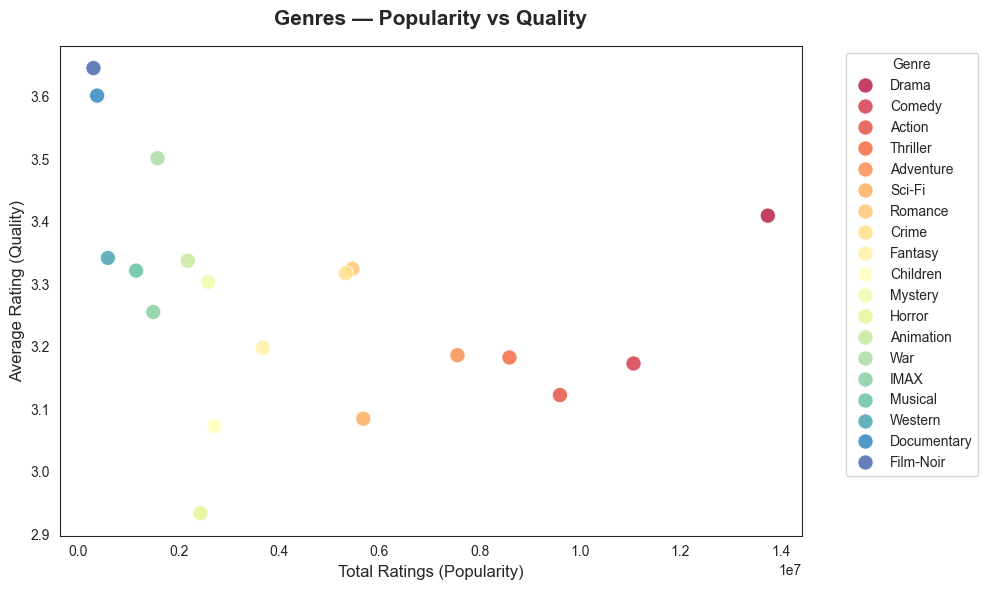

In [186]:

df_scatter = df_moviedetails_exploded.to_pandas()

genre_summary = (
    df_scatter.groupby("genre", as_index=False)
    .agg({
        "average_rating": "mean",
        "rating_count": "sum"
    })
    .sort_values("rating_count", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.scatterplot(
    data=genre_summary,
    x="rating_count",
    y="average_rating",
    hue="genre",
    s=120,
    palette="Spectral",
    alpha=0.85,
    edgecolor="white",
    linewidth=0.7
)

plt.title("Genres — Popularity vs Quality", fontsize=15, weight="bold", pad=15)
plt.xlabel("Total Ratings (Popularity)", fontsize=12)
plt.ylabel("Average Rating (Quality)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Genre")
plt.grid(False)
plt.tight_layout()
plt.show()


### 💡 **Insight**

The visualization clearly shows that the relationship between popularity and quality is weak or even inverse.  
Genres such as **Drama**, **Action**, and **Comedy** attract the largest audiences and therefore accumulate the highest number of ratings — yet their **average ratings hover around 3.0**, suggesting a more mixed audience perception.  

Conversely, genres like **Documentary**, **Film-Noir**, and **IMAX** receive **fewer ratings overall** but stand out with **higher average scores**, indicating that these genres appeal to smaller, more appreciative audiences.  

In short, **popular genres are not necessarily the best rated**, and niche genres tend to deliver higher satisfaction among viewers.


## 🎞️ Question 4 — How have movie ratings evolved over time?

After exploring popularity and genre preferences,  it’s important to examine the **temporal evolution of ratings** —  to understand whether audience behavior and film appreciation have changed over the years.

This analysis aims to uncover **trends in average movie ratings over time**,  helping us identify periods of higher or lower audience satisfaction and potential shifts in rating culture.


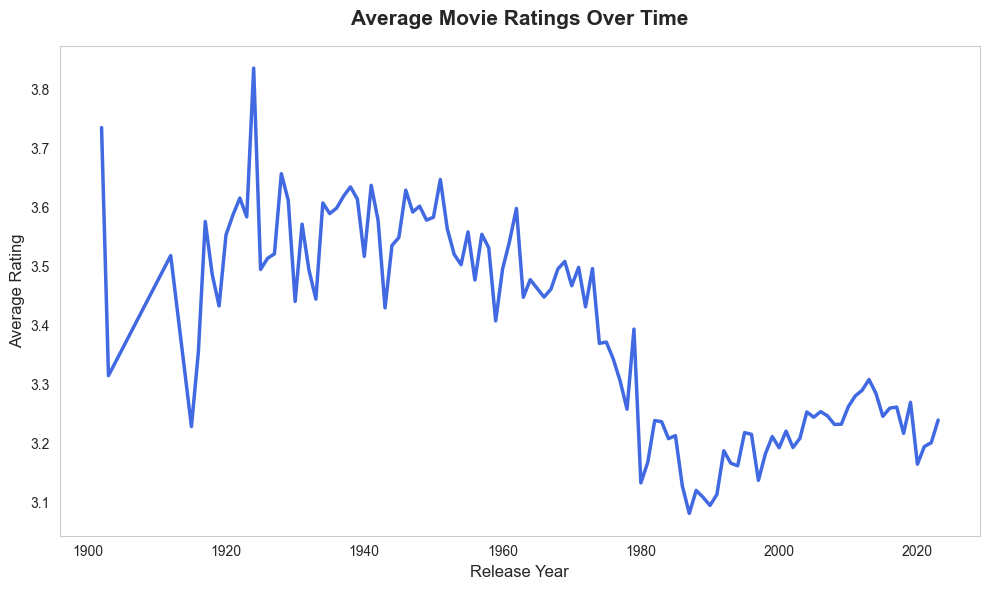

In [187]:
df_time = df_moviedetails.to_pandas()

df_time = df_time[(df_time['year'] >= 1900) & (df_time['year'] <= 2025)]

ratings_over_time = (
    df_time.groupby('year', as_index=False)
    .agg({'average_rating': 'mean', 'rating_count': 'sum'})
)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=ratings_over_time,
    x='year',
    y='average_rating',
    color='royalblue',
    linewidth=2.5
)

plt.title("Average Movie Ratings Over Time", fontsize=15, weight='bold', pad=15)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


### 💡 **Insight**

The trend over time shows that average movie ratings have fluctuated across decades,  with early cinema (pre-1930) showing strong variation — likely due to fewer films and a selective rating base.  

From the **1950s to the 2000s**, ratings appear to stabilize around **3.0 to 3.2**, suggesting  a period of consistent audience perception and more balanced evaluation across genres and styles.  

In the **most recent years**, a slight decline is visible, possibly reflecting a **larger and more diverse rating population**, the **rise of streaming platforms**,  
and the **increased volume of movie production**, which tends to dilute extreme ratings.  

Overall, while audience behavior evolves, the long-term average remains stable, indicating a relatively consistent perception of film quality through time.


## 🌍 Question 5 — How have movie genres evolved over decades?

After exploring which genres are most popular and highest rated,  we now turn to a **temporal perspective** — examining how different genres have evolved in terms of their **average ratings and audience engagement** across decades.  

This question allows us to identify **cultural and cinematic trends** — how preferences shifted from classic dramas to action-packed blockbusters or sci-fi adventures, and whether these shifts align with **technological progress or historical events**.  

By analyzing long-term trends, we can gain insight into how cinema reflects society’s evolving interests, values, and global circumstances.


In [188]:

df_moviedetails_1 = df_moviedetails.with_columns(
    (pl.col("year") // 10 * 10).alias("decade")
)


df_genre_trends = (
    df_moviedetails_1
    .with_columns(pl.col("genres").str.split("|"))
    .explode("genres")
    .group_by(["decade", "genres"])
    .agg([
        pl.col("average_rating").mean().alias("average_rating"),
        pl.col("rating_count").sum().alias("total_ratings")
    ])
    .sort(["genres", "decade"])
)


df_genre_trends = df_genre_trends.to_pandas()

selected_genres = ["Drama", "Comedy", "Action", "Thriller", "Romance"]

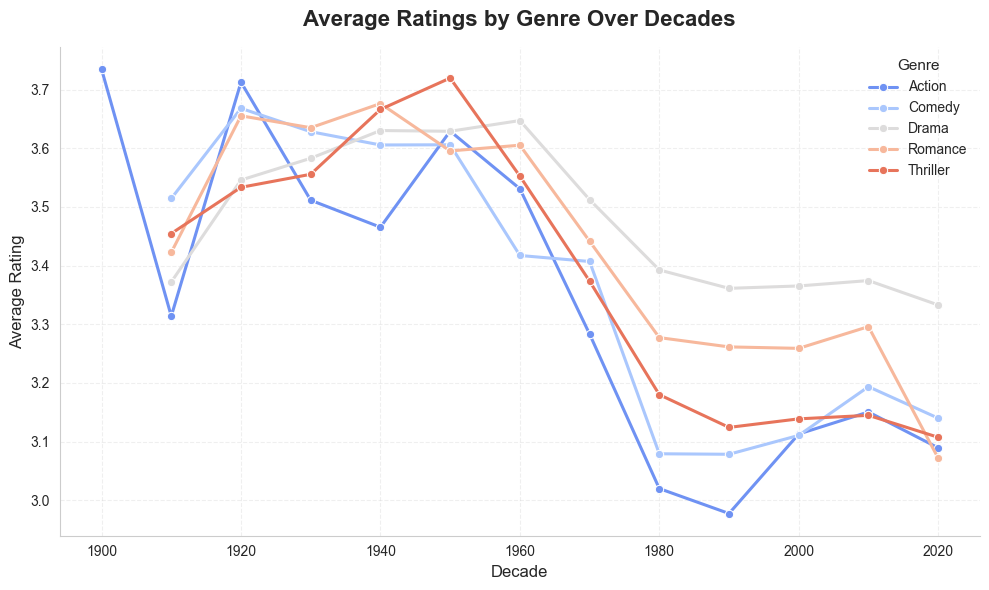

In [189]:

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

palette = sns.color_palette("coolwarm", 5)

sns.lineplot(
    data=df_genre_trends[df_genre_trends["genres"].isin(selected_genres)],
    x="decade", y="average_rating", hue="genres",
    marker="o", linewidth=2.2, palette=palette
)

plt.title("Average Ratings by Genre Over Decades", fontsize=16, weight="bold", pad=15)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Genre", title_fontsize=11, fontsize=10, frameon=False)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

sns.despine()

plt.show()





### 💡 **Insight**

The evolution of average ratings across decades reveals interesting long-term patterns.  
Genres such as **Drama** and **Comedy** have remained relatively stable, maintaining consistent audience appreciation over time.  
Meanwhile, **Action** films show a rise in ratings during the late 20th century — reflecting the technological boom in filmmaking and the rise of blockbuster culture after the 1980s.  

On the other hand, **War** movies present sporadic peaks, often coinciding with or following real-world conflicts (e.g., post–World War II and the early 2000s after the 9/11 attacks), suggesting that global events may subtly influence audience interest in certain genres.  

Overall, while tastes and production styles evolve, cinema’s core genres continue to resonate with audiences, each adapting to the social and cultural context of its time.


## 🎯 **Question 6 — Who are the most active reviewers?**

To explore user engagement, we identify the users who have contributed the **highest number of movie ratings**.  
This helps us understand participation dynamics within the platform — whether user activity is evenly distributed or concentrated among a few highly active individuals.  
Such insights reveal how much influence certain users might have over global trends and the perception of movie popularity or quality.



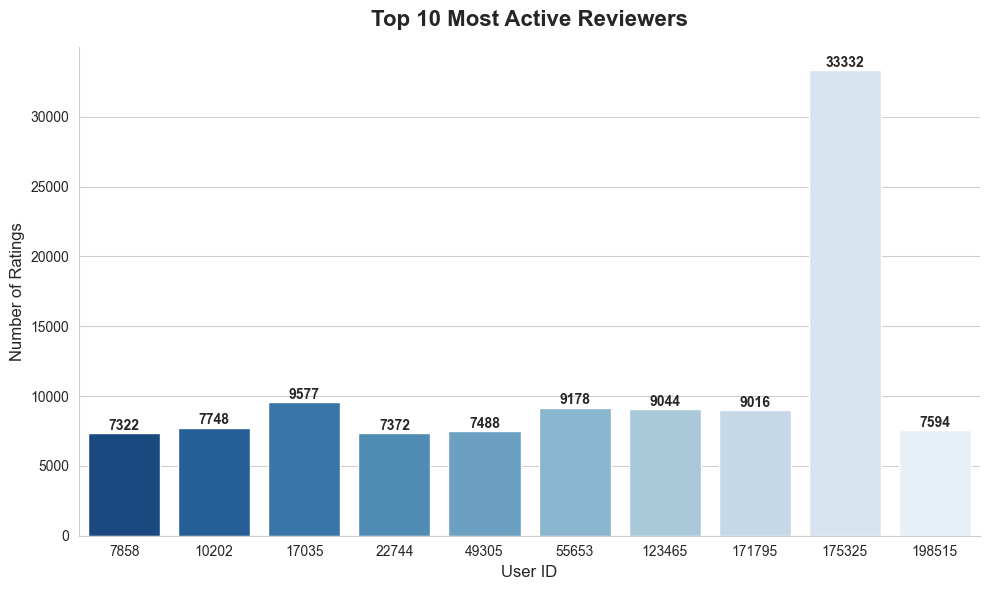

In [190]:

df_ratings_1 = df_ratings.to_pandas() 

df_user_activity = (
    df_ratings_1
    .groupby("userId", as_index=False)
    .agg(n_ratings=("rating", "count"), avg_rating=("rating", "mean"))
    .sort_values(by="n_ratings", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_r", len(df_user_activity))

bars = sns.barplot(
    data=df_user_activity, 
    x="userId", 
    y="n_ratings", 
    hue="userId",        
    palette=palette, 
    legend=False          
)

for bar in bars.patches:
    bars.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 10,
        f"{int(bar.get_height())}",
        ha='center', va='bottom', fontsize=10, weight='bold'
    )

plt.title("Top 10 Most Active Reviewers", fontsize=16, weight="bold", pad=15)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("Number of Ratings", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()



### 💡 **Insight — User Engagement Distribution**

The analysis of user activity shows a **highly uneven distribution of participation**.  
While most of the top reviewers contributed between **7,000 and 9,500 ratings**, one user stands out with more than **33,000 reviews** — over three times higher than any other.  

This highlights the presence of **super-reviewers**, whose behavior significantly shapes overall averages and genre visibility.  
Such users often represent **dedicated, long-term contributors**, but they can also introduce **rating bias** if their preferences dominate the dataset.  

Recognizing this imbalance is essential for improving **recommendation fairness**, **community management**, and ensuring that platform insights reflect the opinions of the wider audience rather than a small subset of extremely active users.


## 🎭 **Question 7 — Do the most active users tend to give higher or lower ratings?**

Building on the previous analysis of reviewer activity, we now explore whether **user engagement correlates with rating behavior**.  
Specifically, we examine if users who rate more movies tend to be **more generous or more critical** in their evaluations.  

Understanding this relationship helps assess potential **bias in rating distributions** — for instance, whether a small number of highly active users might systematically **inflate or deflate overall averages**, influencing how movies are perceived across the platform.  
This analysis provides insight into the **consistency, subjectivity, and reliability** of crowd-based movie evaluations.


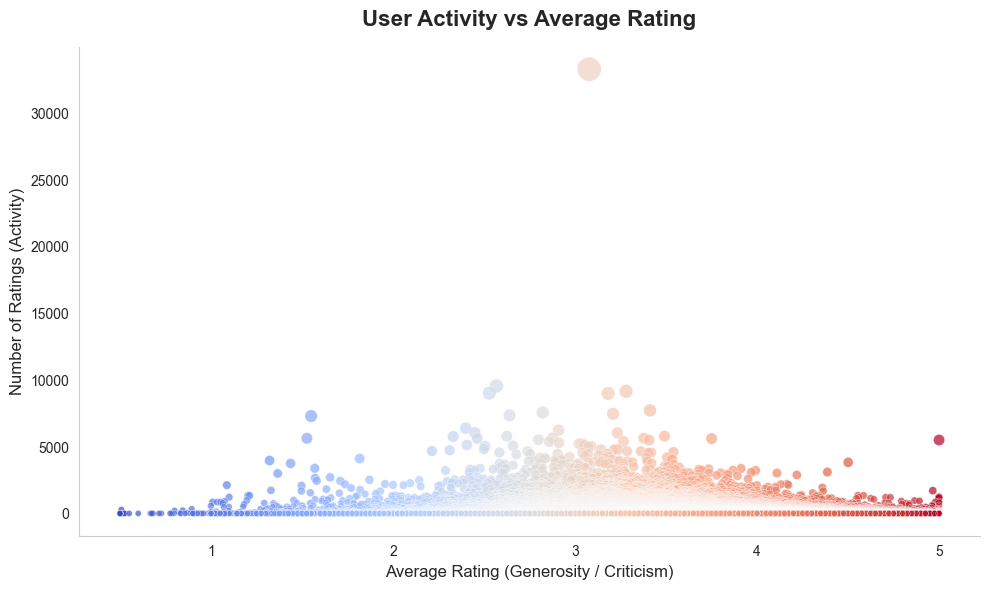

In [191]:
df_user_bias = (
    df_ratings_1
    .groupby("userId", as_index=False)
    .agg(n_ratings=("rating", "count"), avg_rating=("rating", "mean"))
)

df_user_bias = df_user_bias.sort_values(by="n_ratings", ascending=False)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=df_user_bias,
    x="avg_rating",
    y="n_ratings",
    size="n_ratings",
    hue="avg_rating",      
    sizes=(20, 300),
    alpha=0.7,
    palette="coolwarm",
    legend=False         
)

plt.title("User Activity vs Average Rating", fontsize=16, weight="bold", pad=15)
plt.xlabel("Average Rating (Generosity / Criticism)", fontsize=12)
plt.ylabel("Number of Ratings (Activity)", fontsize=12)
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()


### 💡 **Insight — Relationship Between Activity and Rating Behavior**

The scatter plot reveals a clear **concentration of users with few ratings**, most clustering around an **average score between 2.5 and 4.0**.  
This indicates that the majority of users engage casually, rating only a handful of movies while maintaining similar scoring patterns.  

Interestingly, even the **most active reviewers** — those who have rated thousands of movies — do not deviate significantly from this central trend.  
Their average ratings remain close to the overall mean, suggesting that **high activity does not necessarily imply higher generosity or greater criticism**.  

In other words, **user activity is largely independent of rating bias**.  
While a few outliers exist, the overall stability of averages across activity levels indicates a **balanced and consistent evaluation culture** within the platform’s user base.


### 7.1. Analysing the most active user

In [103]:
#Filter ratings made by userid 175325
df_user_175325 = df_ratings.filter(pl.col("userId") == 175325)
df_user_175325.shape

(33332, 5)

In [105]:
df_user_175325_imdb = (
    df_user_175325
    .join(df_links, on="movieId", how="left")
    .with_columns(
        pl.when(pl.col("imdbId").is_not_null())
        .then(pl.concat_str([
            pl.lit("tt"),
            pl.col("imdbId").cast(pl.Utf8).str.zfill(7)
        ]))
        .otherwise(None)
        .alias("tconst")
    )
    .join(
        imdb_df_1.select([
            pl.col("tconst"),
            pl.col("runtimeMinutes").cast(pl.Int64)
        ]),
        on="tconst",
        how="left"
    )
)

In [106]:
df_user_175325_imdb

userId,movieId,rating,timestamp,datetime,imdbId,tmdbId,tconst,runtimeMinutes
i64,i64,f64,i64,datetime[ms],str,i64,str,i64
175325,1,4.0,1450166644,2015-12-15 08:04:04,"""0114709""",862,"""tt0114709""",81
175325,2,3.0,1473241811,2016-09-07 09:50:11,"""0113497""",8844,"""tt0113497""",104
175325,5,2.5,1535602345,2018-08-30 04:12:25,"""0113041""",11862,"""tt0113041""",106
175325,6,4.0,1450164123,2015-12-15 07:22:03,"""0113277""",949,"""tt0113277""",170
175325,7,3.0,1535602345,2018-08-30 04:12:25,"""0114319""",11860,"""tt0114319""",127
…,…,…,…,…,…,…,…,…
175325,217831,2.5,1591976084,2020-06-12 15:34:44,"""0027978""",63744,"""tt0027978""",95
175325,217911,3.5,1591976091,2020-06-12 15:34:51,"""0168632""",125713,"""tt0168632""",51
175325,218043,3.0,1591976095,2020-06-12 15:34:55,"""2024417""",201881,"""tt2024417""",87


In [110]:
#sum the runtime minutes of all movies rated by user 175325 - convert to days

total_runtime_minutes = df_user_175325_imdb.select(pl.col("runtimeMinutes").sum())[0, 0]
total_runtime_days = total_runtime_minutes / (60 * 24)
total_runtime_years = total_runtime_days / 365.25

print(f"Total runtime: {total_runtime_minutes:,} minutes")
print(f"Total runtime: {total_runtime_days:.2f} days")
print(f"Total runtime: {total_runtime_years:.2f} years")


Total runtime: 3,218,964 minutes
Total runtime: 2235.39 days
Total runtime: 6.12 years


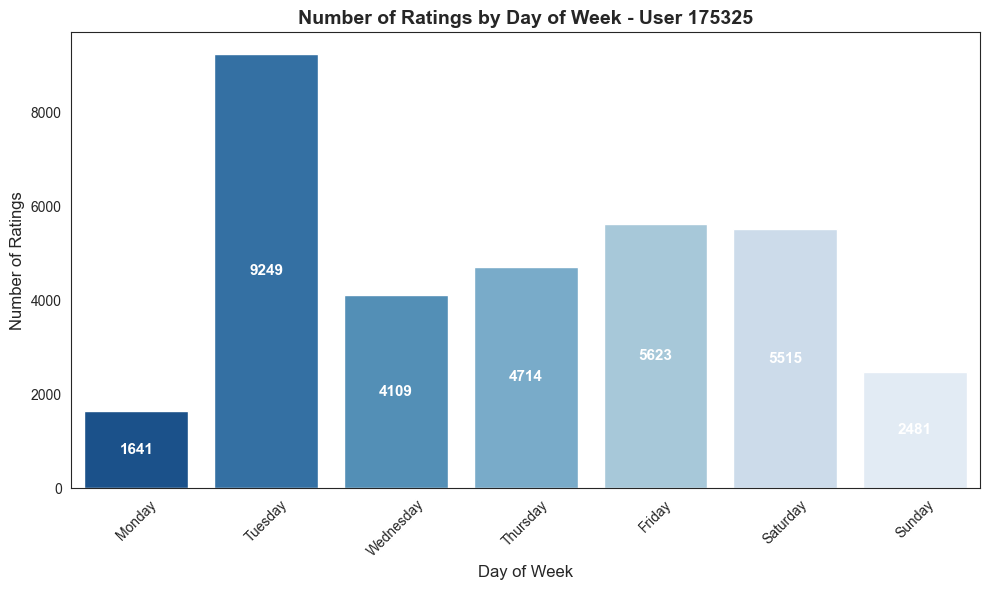

In [116]:
# Extract day of week and count ratings
day_of_week_counts = df_user_175325_imdb.with_columns(
    pl.col("datetime").dt.weekday().alias("day_of_week"),
    pl.col("datetime").dt.strftime("%A").alias("day_name")
).group_by(["day_of_week", "day_name"]).agg(
    pl.len().alias("rating_count")
).sort("day_of_week")

# Convert to pandas and plot
dow_pd = day_of_week_counts.to_pandas()

plt.figure(figsize=(10, 6))
bars = sns.barplot(data=dow_pd, x="day_name", y="rating_count", hue="day_name", palette="Blues_r", legend=False)

# Add count labels inside bars 
for i, (count, day) in enumerate(zip(dow_pd["rating_count"], dow_pd["day_name"])):
    bars.text(
        i, 
        count / 2,  # Middle of the bar
        f"{int(count)}",
        ha="center",
        va="center",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

plt.title("Number of Ratings by Day of Week - User 175325", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Ratings", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🎞️ Question 8 — Do Longer Movies Receive Higher or Lower Ratings?

To go beyond the information contained in the MovieLens dataset, we decided to **integrate an external data source** — the official **IMDb “title.basics” dataset** (via Kaggle).  
This addition allowed us to enrich our analysis with each movie’s **runtime (in minutes)**, enabling a deeper look at whether the *length of a film* influences its *audience rating*.

This step demonstrates the value of **cross-dataset enrichment** in data analysis — combining user behavior (MovieLens) with descriptive metadata (IMDb) to uncover relationships that wouldn’t be visible otherwise.

Our goal:  
Explore whether longer films tend to receive higher or lower ratings on average, and identify if there is an “ideal” duration range for audience appreciation.




In [192]:
#Created on the step 2.2.5 to have all the imports running at the begining of the notebook
#imdb_df = pd.read_csv("data/title.basics.tsv", sep="\t", low_memory=False)

#print(imdb_df.columns)
#imdb_df.head()


Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [54]:
df_moviedetails_duration = df_moviedetails.clone()

In [193]:

df_moviedetails = df_moviedetails.to_pandas()

In [194]:
df_moviedetails_duration = (
    #using df_moviedetails_2 because it is a polars dataframe
    df_moviedetails_duration
    .join(df_links.select(["movieId", "imdbId"]), on="movieId", how="left")
    .join(
        #using imdb_df_1 because it is a polars dataframe
        imdb_df_1.with_columns(
            pl.col("tconst").str.strip_prefix("tt").alias("imdbId")
        ).select(["imdbId", "runtimeMinutes"]), 
        on="imdbId", 
        how="left"
    )
)


df_moviedetails_duration.head()



movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags,year,imdbId,runtimeMinutes
i64,str,str,f64,i64,i64,i64,i64,str,i64
203208,"""Scary Stories to Tell in the D…","""Horror""",2.97006,501,443,10,2019,"""3387520""",108
203222,"""The Lion King""","""Adventure|Animation|Children|D…",3.040597,1207,127,29,2019,"""6105098""",118
203244,"""Shaft""","""Action|Crime""",3.118827,324,16,5,2019,"""4463894""",111
203296,"""Purl""","""Animation|Comedy""",3.342105,57,56,3,2019,"""8980868""",8
203375,"""Ford v. Ferrari""","""Action|Drama""",3.953749,4908,505,105,2019,"""1950186""",152


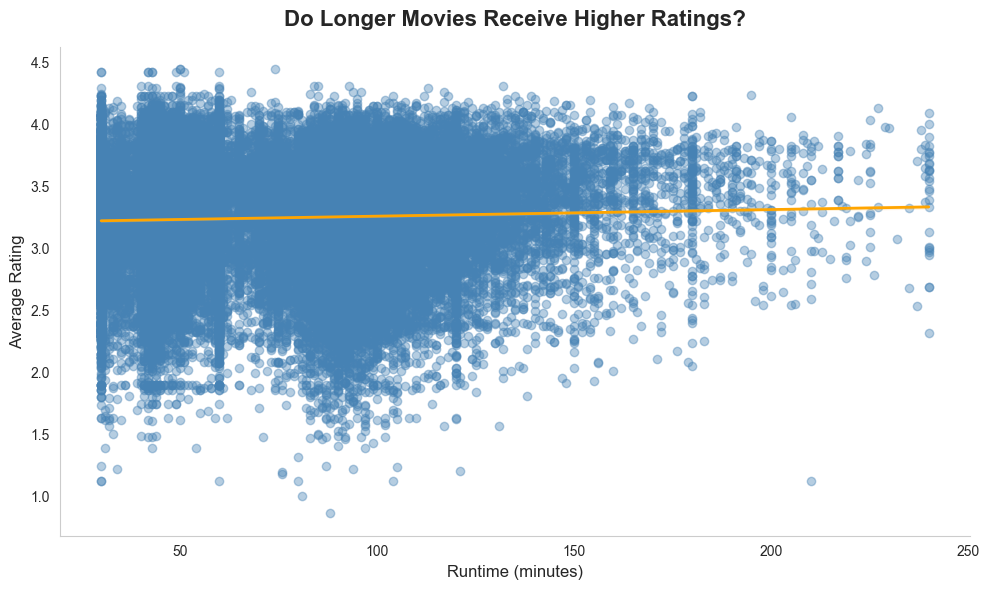

In [195]:
# Filtrar apenas filmes com duração plausível (entre 30 e 240 minutos)
#transform to pandas for the analysis
df_moviedetails_duration = df_moviedetails_duration.to_pandas()


df_moviedetails_duration = df_moviedetails_duration[
    (df_moviedetails_duration["runtimeMinutes"] >= 30) &
    (df_moviedetails_duration["runtimeMinutes"] <= 240)
]

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.regplot(
    data=df_moviedetails_duration,
    x="runtimeMinutes",
    y="average_rating",
    scatter_kws={"alpha":0.4, "color":"#4682b4"},
    line_kws={"color":"#ffa500", "lw":2}
)

plt.title("Do Longer Movies Receive Higher Ratings?", fontsize=16, weight="bold", pad=15)
plt.xlabel("Runtime (minutes)", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\RitaML\AppData\Local\Temp\ipykernel_34932\1302147445.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["runtime_category"] = pd.cut(
C:\Users\RitaML\AppData\Local\Temp\ipykernel_34932\1302147445.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


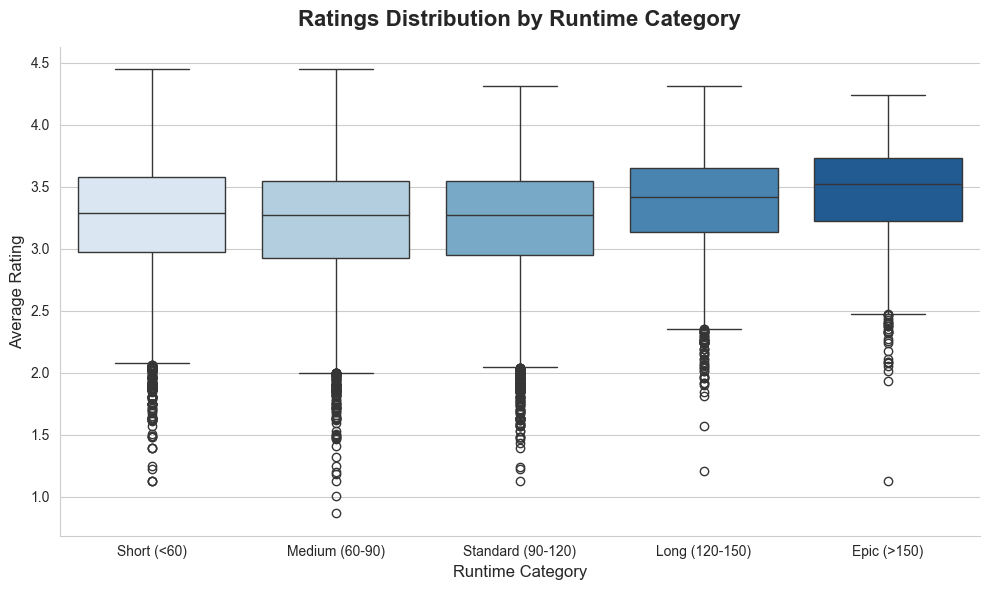

In [196]:
# Criar categorias de duração
bins = [0, 60, 90, 120, 150, 240]
labels = ['Short (<60)', 'Medium (60-90)', 'Standard (90-120)', 'Long (120-150)', 'Epic (>150)']

df_moviedetails_duration["runtime_category"] = pd.cut(
    df_moviedetails_duration["runtimeMinutes"], bins=bins, labels=labels, include_lowest=True
)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.boxplot(
    data=df_moviedetails_duration,
    x="runtime_category",
    y="average_rating",
    palette="Blues"
)

plt.title("Ratings Distribution by Runtime Category", fontsize=16, weight="bold", pad=15)
plt.xlabel("Runtime Category", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()




### 💡 Insights — Does Runtime Influence Audience Appreciation?

1. **Enriching the analysis:**  
   By merging IMDb’s runtime data with MovieLens ratings, we unlocked a new perspective —  examining not just *what people like*, but *how film duration* might affect that perception.

2. **An optimal storytelling window:**  
   The distribution of ratings by runtime shows that films lasting between **90 and 150 minutes**  tend to achieve the **highest median ratings**.  
   Short films (<60 min) exhibit greater variability, while extremely long ones (>150 min) show slightly diminishing returns in audience satisfaction.

3. **Narrative depth vs. audience patience:**  
   The results suggest that longer films often benefit from **richer storytelling** and **emotional complexity**, but **excessive duration doesn’t guarantee quality** — balance appears to be key.

🎬 **In summary:**  
Integrating IMDb data transformed this question from a simple statistical exercise into a **multi-source exploration of storytelling dynamics**, revealing that audience appreciation thrives on **narrative balance rather than sheer duration**.




## 🎞️ Question 9 — Did user behavior change around the COVID-19 pandemic?

It might be interesting to analyze of the weekly number of ratings and weekly average rating shift after 11-03-2020- the OMS official declaration of COVID-19 pandemic.


In [197]:
print(type(df_ratings))


<class 'polars.dataframe.frame.DataFrame'>


In [198]:
df_ratings = pl.from_pandas(df_ratings)

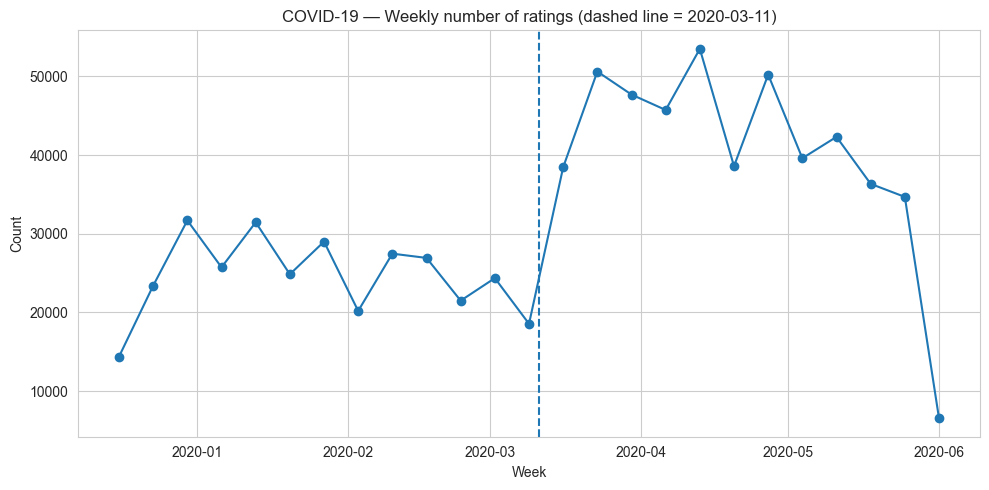

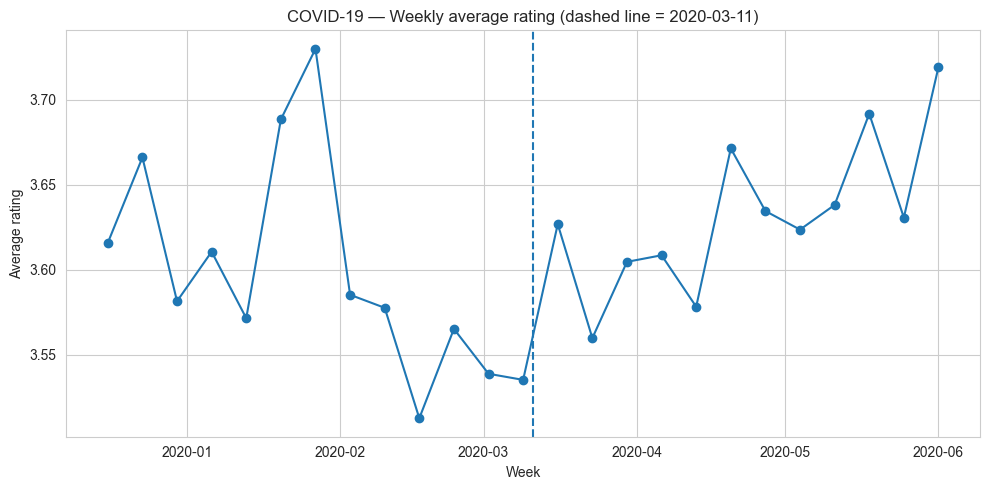

,period,avg_weekly_count,avg_weekly_rating
0,12 weeks before,24586.615385,3.598464
1,12 weeks after,40367.166667,3.632401


In [199]:
# COVID-19 impact (WHO: 2020-03-11)
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

#code works for polars df

if "datetime" not in df_ratings.columns:
    df_ratings = df_ratings.with_columns(
        (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
    )

t0 = pd.Timestamp("2020-03-11")
win_start = t0 - pd.Timedelta(weeks=12)
win_end   = t0 + pd.Timedelta(weeks=12)


weekly = (
    df_ratings
    .filter(pl.col("datetime").is_between(win_start, win_end))
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .group_by("week")
    .agg([
        pl.len().alias("n_ratings"),
        pl.col("rating").mean().alias("avg_rating")
    ])
    .sort("week")
    .to_pandas()
)

# Plot weekly counts
plt.figure(figsize=(10,5))
plt.plot(weekly["week"], weekly["n_ratings"], marker="o")
plt.axvline(t0, linestyle="--")
plt.title("COVID-19 — Weekly number of ratings (dashed line = 2020-03-11)")
plt.xlabel("Week"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Plot weekly averages
plt.figure(figsize=(10,5))
plt.plot(weekly["week"], weekly["avg_rating"], marker="o")
plt.axvline(t0, linestyle="--")
plt.title("COVID-19 — Weekly average rating (dashed line = 2020-03-11)")
plt.xlabel("Week"); plt.ylabel("Average rating")
plt.tight_layout(); plt.show()

# Before vs after summary (12 weeks)
before = weekly[weekly["week"] < t0]
after  = weekly[weekly["week"] >= t0]
covid_summary = pd.DataFrame({
    "period": ["12 weeks before", "12 weeks after"],
    "avg_weekly_count": [before["n_ratings"].mean(), after["n_ratings"].mean()],
    "avg_weekly_rating": [before["avg_rating"].mean(), after["avg_rating"].mean()]
})
covid_summary


### 💡 Insights - Did the lockdown affect weekly number of ratings and average rating?

The top chart shows a sharp increase in weekly number of ratings immediately after March 11 2020 (the dashed line).
This suggests that, once lockdowns started and people spent more time at home, platform activity surged — more users rating more movies.
The bottom chart shows that the average rating stayed roughly stable, hovering around 3.6: people rated more movies, but their evaluation standards did not shift.
In general, the lockdonws mainly increased volume, not sentiment.

###  **9.1. Top 20 movies after March 11 until December 31 2020**

In [ ]:
#Using Ratings polars dataframe to get covid ratings between the 11th March 2020 and December 31 2020
df_covid_ratings = df_ratings.filter(
    (pl.col("datetime") >= pl.datetime(2020, 3, 11)) &
    (pl.col("datetime") < pl.datetime(2021, 1, 1))
).group_by("movieId").agg(
    pl.len().alias("covid_rating_count"),
    pl.col("rating").mean().alias("covid_avg_rating")
)

df_covid_ratings.head()

movieId,covid_rating_count,covid_avg_rating
i64,u32,f64
223898,1,0.5
112753,2,2.25
176589,2,3.5
94919,2,2.0
188263,1,1.0


In [96]:
#Join with df_movies to get movie titles
df_covid_movies = df_movies.join(
    df_covid_ratings,
    on="movieId",
    how="inner"  # or "left" if you want to keep all movies even without COVID ratings
)

df_covid_movies.head()

movieId,title,genres,covid_rating_count,covid_avg_rating
i64,str,str,u32,f64
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…",1951,3.943875
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy""",711,3.553446
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""",49,2.908163
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance""",4,2.5
5,"""Father of the Bride Part II (1…","""Comedy""",74,2.912162


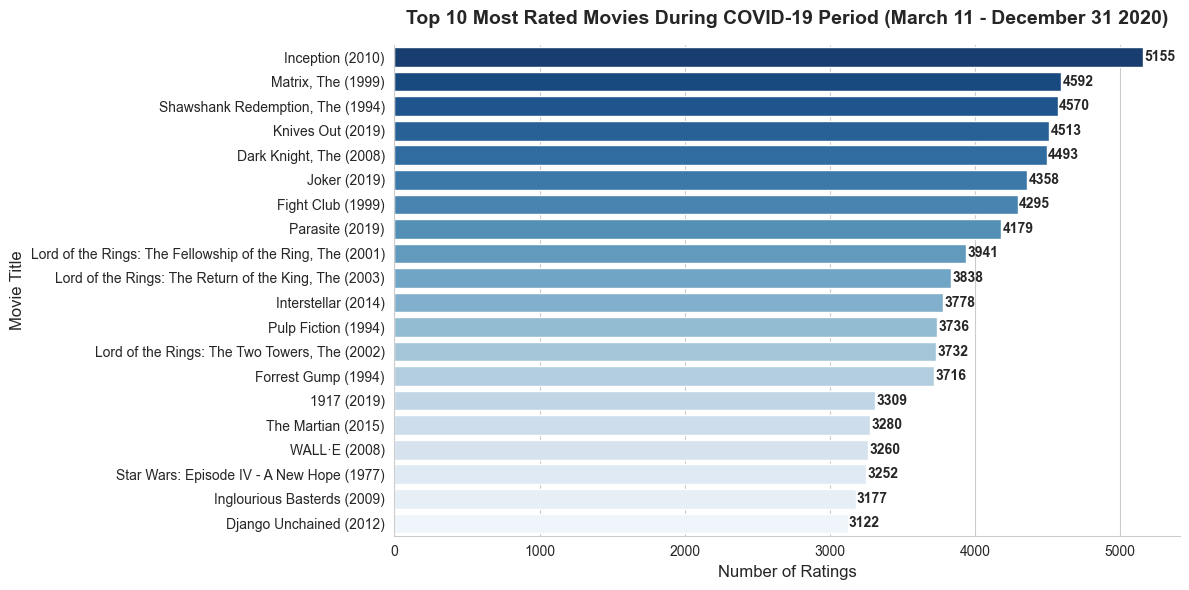

In [98]:
# Get top movies by rating count in the COVID period
top_covid_movies = df_covid_movies.sort("covid_rating_count", descending=True).head(20)

# Convert to pandas for visualization
top_covid_pd = top_covid_movies.to_pandas()

# Create bar plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

bars = sns.barplot(
    data=top_covid_pd,
    x="covid_rating_count",
    y="title",
    palette="Blues_r",
    hue="title",  # Add this if using newer seaborn
    legend=False  # Add this if using hue
)

# Add count labels on bars
for i, (count, title) in enumerate(zip(top_covid_pd["covid_rating_count"], top_covid_pd["title"])):
    bars.text(
        count + 10, i,
        f"{int(count)}",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

plt.title("Top 10 Most Rated Movies During COVID-19 Period (March 11 - December 31 2020)", 
          fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Number of Ratings", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [99]:
#Join with df_movies to get movie titles
df_covid_moviesdetails = df_moviedetails.join(
    df_covid_ratings,
    on="movieId",
    how="inner"  # or "left" if you want to keep all movies even without COVID ratings
)

df_covid_moviesdetails.head()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_tags,year,covid_rating_count,covid_avg_rating
i64,str,str,f64,i64,i64,i64,i64,u32,f64
3820,"""Thomas and the Magic Railroad""","""Children""",1.870892,213,3,2,2000,1,1.0
4984,"""Morgan!""","""Comedy|Drama|Fantasy""",3.335821,67,8,4,1966,1,0.5
112473,"""Stuart: A Life Backward""","""Drama""",3.817073,82,25,4,2007,4,3.75
8655,"""Rustlers' Rhapsody""","""Comedy|Western""",3.183824,68,1,1,1985,1,3.0
157296,"""Finding Dory""","""Adventure|Animation|Comedy""",3.537607,5624,104,33,2016,673,3.447251


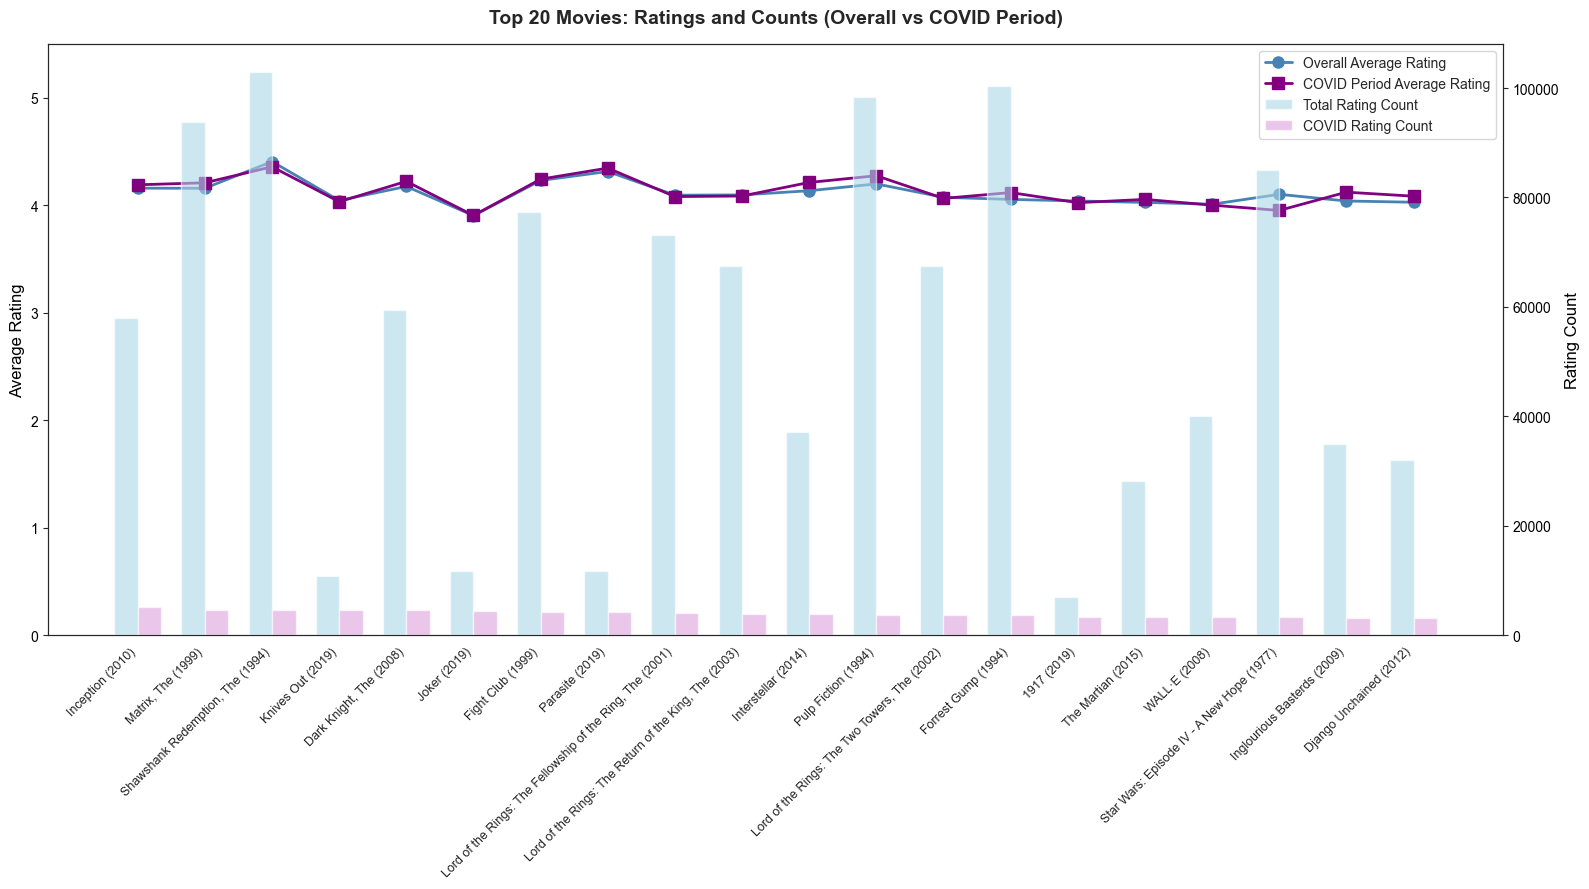

In [ ]:
# Get top 20 movies by COVID rating count
top20_covid = df_covid_moviesdetails.sort("covid_rating_count", descending=True).head(20)

# Convert to pandas for plotting
top20_pd = top20_covid.to_pandas()

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

x = range(len(top20_pd))

# First y-axis: Average Ratings (lines)
ax1.plot(x, top20_pd["average_rating"], marker='o', linewidth=2, markersize=8, 
         label='Overall Average Rating', color='steelblue')
ax1.plot(x, top20_pd["covid_avg_rating"], marker='s', linewidth=2, markersize=8, 
         label='COVID Period Average Rating', color='purple')
ax1.set_ylabel("Average Rating", fontsize=12, color='black')
ax1.set_ylim(0, 5.5)
ax1.tick_params(axis='y', labelcolor='black')

# Second y-axis: Rating Counts (bars)
ax2 = ax1.twinx()
width = 0.35
ax2.bar([i - width/2 for i in x], top20_pd["rating_count"], width, 
        label='Total Rating Count', color='lightblue', alpha=0.6)
ax2.bar([i + width/2 for i in x], top20_pd["covid_rating_count"], width, 
        label='COVID Rating Count', color='plum', alpha=0.6)
ax2.set_ylabel("Rating Count", fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Customize x-axis
ax1.set_xticks(x)
labels = [f"{title} ({year})" for title, year in zip(top20_pd["title"], top20_pd["year"])]
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)


# Title and legends
plt.title("Top 20 Movies: Ratings and Counts (Overall vs COVID Period)", 
          fontsize=14, fontweight="bold", pad=15)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## ⚔️ Question 10 —Did the Ukraine war influence user interest in war- or reality-based genres?

In this analysis, we test whether audience engagement shifted after the beginning of the Russia-Ukraine war — specifically, whether the share of ratings for War and Documentary films increased relative to total platform activity.

In [200]:
print (type(df_moviedetails))

<class 'polars.dataframe.frame.DataFrame'>


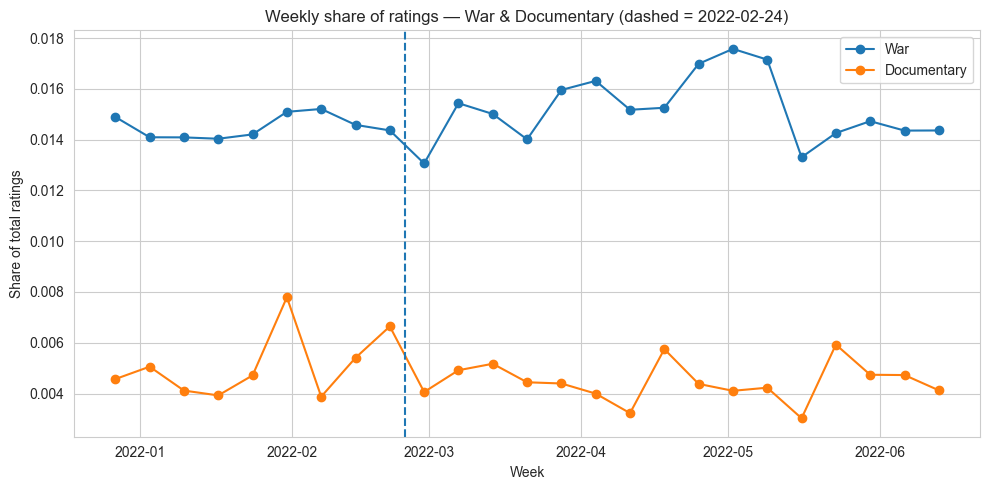

War: mean share before=0.0145  after=0.0152  Δ=+0.0007
Documentary: mean share before=0.0051  after=0.0045  Δ=-0.0007


In [201]:
# Ukraine war impact (invasion: 2022-02-24)
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

#df_ratings = pl.DataFrame(df_ratings)
#df_moviedetails = pl.from_pandas(df_moviedetails)


# Ensure ratings have datetime
if "datetime" not in df_ratings.columns:
    df_ratings = df_ratings.with_columns(
        (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
    )

t0 = pd.Timestamp("2022-02-24")
win_start = t0 - pd.Timedelta(weeks=8)
win_end   = t0 + pd.Timedelta(weeks=16)

# Map movieId -> genres (explode multi-genre)
genres_map = (
    df_moviedetails
    .with_columns(
        pl.when(pl.col("genres").str.to_lowercase().str.strip_chars() == "(no genres listed)")
          .then(None).otherwise(pl.col("genres")).alias("genres")
    )
    .with_columns(pl.col("genres").str.split("|"))
    .explode("genres")
    .select(["movieId", "genres"])
)

# Ratings in window + genres
ratings_win = (
    df_ratings
    .filter(pl.col("datetime").is_between(win_start, win_end))
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .join(genres_map, on="movieId", how="left")
)

weekly_total = (
    ratings_win
    .group_by("week")
    .agg(pl.len().alias("n_total"))
)

weekly_target = (
    ratings_win
    .filter(pl.col("genres").is_in(["War", "Documentary"]))
    .group_by(["week", "genres"])
    .agg(pl.len().alias("n_genre"))
)

share = (
    weekly_target
    .join(weekly_total, on="week", how="left")
    .with_columns((pl.col("n_genre") / pl.col("n_total")).alias("share"))
    .sort(["week", "genres"])
    .to_pandas()
)

# Plot weekly share
plt.figure(figsize=(10,5))
for g in ["War", "Documentary"]:
    s = share[share["genres"] == g]
    plt.plot(s["week"], s["share"], marker="o", label=g)
plt.axvline(t0, linestyle="--")
plt.title("Weekly share of ratings — War & Documentary (dashed = 2022-02-24)")
plt.xlabel("Week"); plt.ylabel("Share of total ratings")
plt.legend(); plt.tight_layout(); plt.show()

# Before vs after averages (shares)
def avg_share(genre: str):
    s = share[share["genres"] == genre]
    return s[s["week"] < t0]["share"].mean(), s[s["week"] >= t0]["share"].mean()

for g in ["War", "Documentary"]:
    b, a = avg_share(g)
    print(f"{g}: mean share before={b:.4f}  after={a:.4f}  Δ={(a-b):+.4f}")


### 💡 Insights - Did the share of ratings for War and Documentary films change after the start of the war?

The dashed line marks the start of the invasion on 2022-02-24. After this date, the share of ratings for War films slightly increased, reaching its highest levels between March and May 2022.
The Documentary genre also shows short-term spikes in February and April, suggesting bursts of user interest in factual content.

We concluded that after February 24 2022, the share of ratings for War and Documentary films rose briefly, reflecting increased audience attention to conflict-related and factual content following the outbreak of the Ukraine war. The trend stabilised later, suggesting a short-term cultural response rather than a permanent shift in preferences.

# Bonus Question: 12 Monkeys Movie across time

In [202]:
df_moviedetails_exploded.filter(pl.col("title").str.contains("Monkeys"))

movieId,title,genre,year,average_rating,rating_count
i64,str,str,i64,f64,i64
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Mystery""",1995,3.910185,55275
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Sci-Fi""",1995,3.910185,55275
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Thriller""",1995,3.910185,55275
63698,"""Three Monkeys (Üç maymun)""","""Drama""",2008,3.548276,145


12 Monkeys is a movie from 1995 with the categories Mystery, Thriller and Sci-Fi. It has the following description on IMDb:
> In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.

It could be interesting to see if this movie spiked interest during the COVID-19 pandemic.

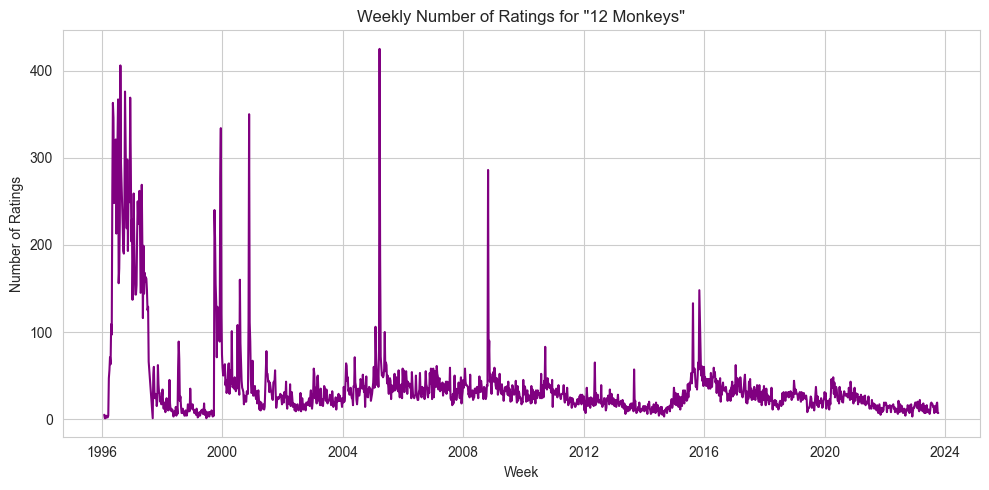

In [203]:
# Build a line graph showing the number of ratings for "12 Monkeys" over time
# between 2019 and 2024
movie_title = "12 Monkeys"
movie_id = 32
ratings_12_monkeys = (
    df_ratings
    .filter(pl.col("movieId") == movie_id)
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .group_by("week")
    .agg(pl.len().alias("n_ratings"))
    .sort("week")
    .to_pandas()
)
plt.figure(figsize=(10,5))
plt.plot(ratings_12_monkeys["week"], ratings_12_monkeys["n_ratings"], 
         #marker="o", 
         color="purple")
plt.title(f'Weekly Number of Ratings for "{movie_title}"')
plt.xlabel("Week")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.show()

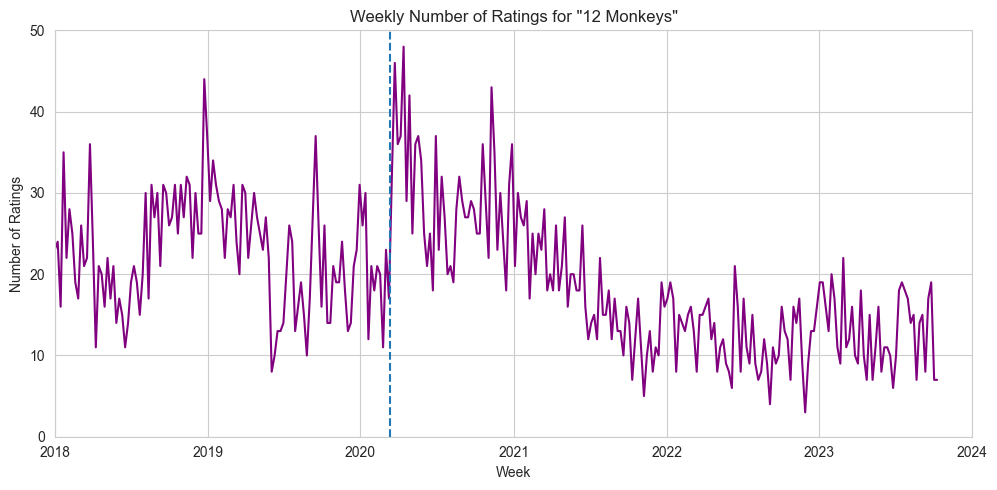

In [204]:
# Build a line graph showing the number of ratings for "12 Monkeys" over time between 2019 and 2024
import datetime
movie_title = "12 Monkeys"
movie_id = 32
ratings_12_monkeys = (
    df_ratings
    .filter(pl.col("movieId") == movie_id)
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .group_by("week")
    .agg(pl.len().alias("n_ratings"))
    .sort("week")
    .to_pandas()
)
plt.figure(figsize=(10,5))
plt.plot(ratings_12_monkeys["week"], ratings_12_monkeys["n_ratings"], 
         #marker="o", 
         color="purple")
plt.title(f'Weekly Number of Ratings for "{movie_title}"')
plt.xlabel("Week")
plt.ylabel("Number of Ratings")
plt.tight_layout()
ax = plt.gca()
ax.set_xlim([datetime.date(2018,1,1), datetime.date(2024,1,1)])
ax.set_ylim([0, 50])
t0 = pd.Timestamp("2020-03-11")
plt.axvline(t0, linestyle="--")
plt.show()

In [205]:
ratings_12_monkeys

,week,n_ratings
0,1996-01-29,5
1,1996-02-05,1
2,1996-02-12,1
3,1996-02-19,4
4,1996-02-26,2
...,...,...
1435,2023-09-11,8
1436,2023-09-18,17
1437,2023-09-25,19
1438,2023-10-02,7


# Bonus Bonus Question

In [206]:
df_moviedetails_exploded.filter(pl.col("title").str.contains("Busan"))

movieId,title,genre,year,average_rating,rating_count
i64,str,str,i64,f64,i64
162082,"""Train to Busan""","""Action""",2016,3.836145,3201
162082,"""Train to Busan""","""Thriller""",2016,3.836145,3201


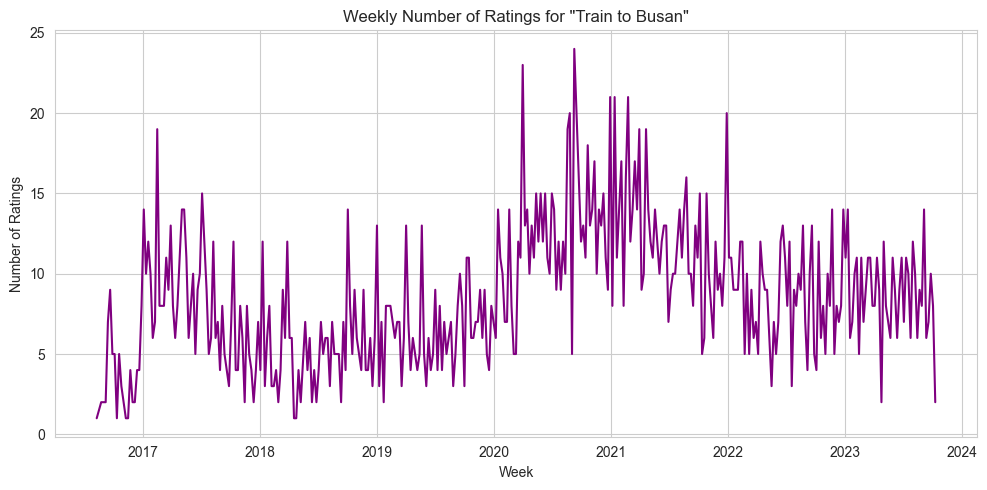

In [207]:
# Build a line graph showing the number of ratings for "12 Monkeys" over time
# between 2019 and 2024
movie_title = "Train to Busan"
movie_id = 162082
ratings_ttb = (
    df_ratings
    .filter(pl.col("movieId") == movie_id)
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .group_by("week")
    .agg(pl.len().alias("n_ratings"))
    .sort("week")
    .to_pandas()
)
plt.figure(figsize=(10,5))
plt.plot(ratings_ttb["week"], ratings_ttb["n_ratings"], 
         #marker="o", 
         color="purple")
plt.title(f'Weekly Number of Ratings for "{movie_title}"')
plt.xlabel("Week")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.show()

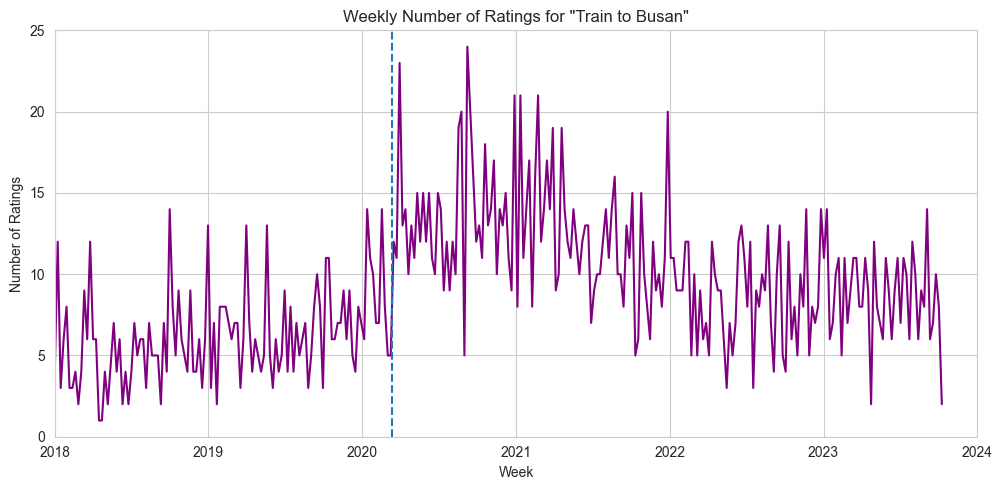

In [208]:
# Build a line graph showing the number of ratings for "12 Monkeys" over time between 2019 and 2024
import datetime
movie_title = "Train to Busan"
movie_id = 162082
ratings_ttb = (
    df_ratings
    .filter(pl.col("movieId") == movie_id)
    .with_columns(pl.col("datetime").dt.truncate("1w").alias("week"))
    .group_by("week")
    .agg(pl.len().alias("n_ratings"))
    .sort("week")
    .to_pandas()
)
plt.figure(figsize=(10,5))
plt.plot(ratings_ttb["week"], ratings_ttb["n_ratings"], 
         #marker="o", 
         color="purple")
plt.title(f'Weekly Number of Ratings for "{movie_title}"')
plt.xlabel("Week")
plt.ylabel("Number of Ratings")
plt.tight_layout()
ax = plt.gca()
ax.set_xlim([datetime.date(2018,1,1), datetime.date(2024,1,1)])
ax.set_ylim([0, 25])
t0 = pd.Timestamp("2020-03-11")
plt.axvline(t0, linestyle="--")
plt.show()

## **5. 🎬  Conclusions & Future Work**

The analysis of the MovieLens 32M dataset shows that movie ratings are driven mainly by genre, number of ratings, and film popularity.
Genre remains the most decisive factor: Documentary, Film-Noir and IMAX consistently achieve the highest average scores, whereas popular mainstream genres such as Drama, Action & Thriller attract larger audiences. Popularity itself seems to act as a stabilizer — the more ratings a movie receives, the more moderate its final average becomes.

User activity patterns are equally revealing. Even the most prolific users rate films with similar distributions to casual viewers, suggesting that the platform supports a balanced and consistent evaluation culture rather than bias from heavy users.

The temporal dimension highlights how external events can momentarily shape audience focus without deeply altering evaluation standards. During the COVID-19 pandemic, platform activity grew sharply as people turned to films for comfort and connection during lockdown times. Similarly, following the war in Ukraine, attention briefly shifted toward War and Documentary genres, reflecting a societal search for context. Overall, user behavior reacts to global circumstances but quickly returns to its steady patterns.

Looking ahead, with more user-centered data, this study could be extended by developing a user-level collaborative filtering model to predict individual ratings based on shared preferences. Integrating semantic movie tags and metadata could further enhance predictions, allowing richer representations of content beyond genre. This combination would bridge statistical modeling with human interpretation, enabling a deeper understanding of how people engage with cinema across time and context.